# Loading + Training the Model

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW, get_scheduler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from tqdm.auto import tqdm

# Load the Dataset
data_files = {"train": "/Users/heyodogo/Downloads/emobank_train.csv", "test": "/Users/heyodogo/Downloads/emobank_test.csv"}
dataset = load_dataset('csv', data_files=data_files)
dataset = dataset.remove_columns(['id', 'D', 'split'])
dataset = dataset.rename_column("V", "label1")
dataset = dataset.rename_column("A", "label2")

# Merge labels into a single array per example
def merge_labels(example):
    example['labels'] = [example['label1'], example['label2']]
    return example

dataset = dataset.map(merge_labels)
dataset = dataset.remove_columns(['label1', 'label2'])

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

# DataLoaders
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8, collate_fn=data_collator)

# Model Setup for Multi-output Regression
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # Output two values
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Training Setup
optimizer = AdamW(model.parameters(), lr=3e-5)
loss_fn = nn.MSELoss()
num_epochs = 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_epochs * len(train_dataloader))

# Training Loop
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        targets = torch.tensor(batch['labels']).float().to(model.device)
        loss = loss_fn(outputs.logits, targets)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/heyodogo/Documents/DrOng/jupyter/class-env/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/114 [00:00<?, ?it/s]

/var/folders/35/m4pyz3mj6cs9h3dqwphg5f0r0000gn/T/ipykernel_66534/1013880550.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(batch['labels']).float().to(model.device)


# Evaluating the Model

In [256]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW, get_scheduler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from tqdm.auto import tqdm

# Load the Dataset
data_files = {"train": "/Users/heyodogo/Downloads/emobank_train.csv", "test": "/Users/heyodogo/Downloads/emobank_test.csv"}
dataset = load_dataset('csv', data_files=data_files)
dataset = dataset.remove_columns(['id', 'D', 'split'])
dataset = dataset.rename_column("V", "label1")
dataset = dataset.rename_column("A", "label2")

# Merge labels into a single array per example
def merge_labels(example):
    example['labels'] = [example['label1'], example['label2']]
    return example

dataset = dataset.map(merge_labels)
dataset = dataset.remove_columns(['label1', 'label2'])

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

# # DataLoaders
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8, collate_fn=data_collator)

# Assume model and eval_dataloader are already defined, and device is set
model.eval()
actuals_label1 = []
actuals_label2 = []
predictions_label1 = []
predictions_label2 = []

with torch.no_grad():
    for batch in eval_dataloader:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        labels = batch["labels"].float().to(model.device)
        outputs = model(**batch)
        logits = outputs.logits
        # Assuming outputs.logits shape is [batch_size, 2]
        predictions_label1.extend(outputs.logits[:, 0].cpu().numpy())
        predictions_label2.extend(outputs.logits[:, 1].cpu().numpy())
        actuals_label1.extend(labels[:, 0].cpu().numpy())
        actuals_label2.extend(labels[:, 1].cpu().numpy())

# Calculate evaluation metrics for each label
mae_label1 = mean_absolute_error(actuals_label1, predictions_label1)
mse_label1 = mean_squared_error(actuals_label1, predictions_label1)
rmse_label1 = np.sqrt(mse_label1)
r_squared_label1 = r2_score(actuals_label1, predictions_label1)

mae_label2 = mean_absolute_error(actuals_label2, predictions_label2)
mse_label2 = mean_squared_error(actuals_label2, predictions_label2)
rmse_label2 = np.sqrt(mse_label2)
r_squared_label2 = r2_score(actuals_label2, predictions_label2)

print(f"Valence label - Mean Absolute Error (MAE): {mae_label1:.4f}")
print(f"Valence label - Mean Squared Error (MSE): {mse_label1:.4f}")
print(f"Valence label - Root Mean Squared Error (RMSE): {rmse_label1:.4f}")
print(f"Valence label - R-squared: {r_squared_label1:.4f}")

print(f"Arousal label - Mean Absolute Error (MAE): {mae_label2:.4f}")
print(f"Arousal label - Mean Squared Error (MSE): {mse_label2:.4f}")
print(f"Arousal label - Root Mean Squared Error (RMSE): {rmse_label2:.4f}")
print(f"Arousal label - R-squared: {r_squared_label2:.4f}")

Valence label - Mean Absolute Error (MAE): 0.2513
Valence label - Mean Squared Error (MSE): 0.1581
Valence label - Root Mean Squared Error (RMSE): 0.3977
Valence label - R-squared: 0.3618
Arousal label - Mean Absolute Error (MAE): 0.1648
Arousal label - Mean Squared Error (MSE): 0.0454
Arousal label - Root Mean Squared Error (RMSE): 0.2130
Arousal label - R-squared: 0.2489


# Plotting the residuals for both Valence and Arousal Labels

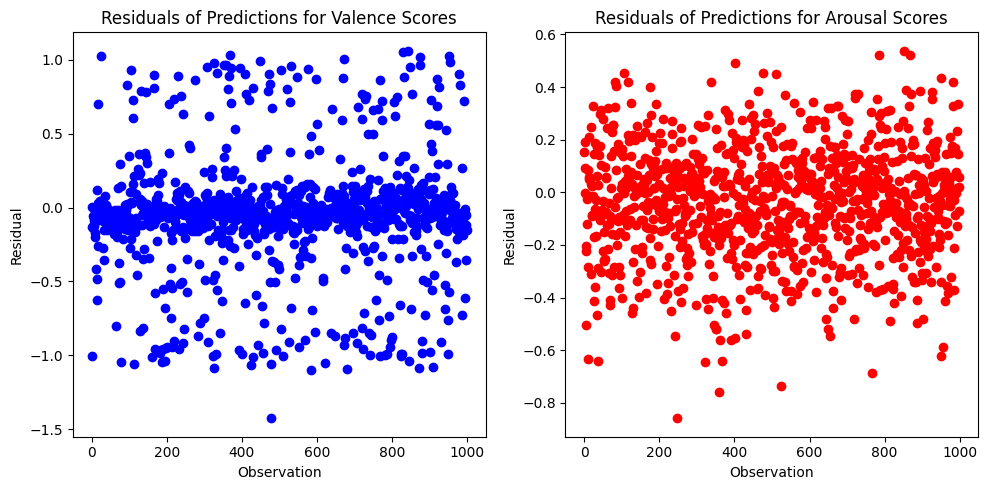

In [189]:
import matplotlib.pyplot as plt

residuals_label1 = [actual - pred for actual, pred in zip(actuals_label1, predictions_label1)]
residuals_label2 = [actual - pred for actual, pred in zip(actuals_label2, predictions_label2)]

# Plotting the residuals for Valence
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.plot(residuals_label1, marker='o', linestyle='', color='blue')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.title('Residuals of Predictions for Valence Scores')

# Plotting the residuals for Arousal
plt.subplot(1, 2, 2) 
plt.plot(residuals_label2, marker='o', linestyle='', color='red')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.title('Residuals of Predictions for Arousal Scores')

plt.tight_layout()
plt.show()

# Testing the model on random new text

In [21]:
model = AutoModelForSequenceClassification.from_pretrained("/Users/heyodogo/Documents/cascoglab/model")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

new_text = "this is so cool, testing text"

model.eval()  
inputs = tokenizer(new_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():  
    outputs = model(**inputs)

predicted_values = outputs.logits.squeeze() 
print("Predicted values for Valence:", predicted_values.tolist()[0]) 
print("Predicted values for Arousal:", predicted_values.tolist()[1]) 

Predicted values for Valence: 3.200925588607788
Predicted values for Arousal: 3.5505919456481934


# Running the model through the comments


In [72]:
import os

model = AutoModelForSequenceClassification.from_pretrained("/Users/heyodogo/Documents/cascoglab/model")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model.eval()

def predict(text):
    torch.cuda.empty_cache()  
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.squeeze()
    return logits.detach().cpu().numpy()  

input_directory_path = '/Users/heyodogo/Documents/projectfiles/sports/sports_comments copy/asd'
output_directory_path = '/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score'

os.makedirs(output_directory_path, exist_ok=True)

csv_files = [f for f in os.listdir(input_directory_path) if f.endswith('.csv')]
for file_name in csv_files:
    file_path = os.path.join(input_directory_path, file_name)
    df = pd.read_csv(file_path)

    if 'Comments' in df.columns:
        results = []
        for comment in tqdm(df['Comments'].dropna(), desc=f"Processing {file_name}"):
            valence, arousal = predict(comment)
            results.append({'Valence': valence, 'Arousal': arousal})

        # Create DataFrame from results and save
        results_df = pd.DataFrame(results)
        new_file_name = file_name.replace('.csv', '_scores.csv')
        new_file_path = os.path.join(output_directory_path, new_file_name)
        results_df.to_csv(new_file_path, index=False)
        print(f"Scores written to: {new_file_name}")


Processing Arsenal v. Newcastle United.txt.csv:   0%|          | 0/505 [00:00<?, ?it/s]

Scores written to: Arsenal v. Newcastle United.txt_scores.csv


Processing NUGGETS at LAKERS | FULL GAME HIGHLIGHTS | March 2, 2024.comments.txt.csv:   0%|          | 0/1895 …

Scores written to: NUGGETS at LAKERS | FULL GAME HIGHLIGHTS | March 2, 2024.comments.txt_scores.csv


# Running the model through the transcriptions 


In [33]:
input_directory_path = '/Users/heyodogo/Documents/audio downloads/learning/news_transcriptions'
output_directory_path = '/Users/heyodogo/Documents/audio downloads/learning/news_transcriptions_scores'

# Create output directory if it doesn't exist
os.makedirs(output_directory_path, exist_ok=True)

# Process each text file in the directory
text_files = [f for f in os.listdir(input_directory_path) if f.endswith('.txt')]
for file_name in text_files:
    file_path = os.path.join(input_directory_path, file_name)
    with open(file_path, 'r') as file:
        text_content = file.read()

    # Assume the text file contains enough content to be split into valence and arousal
    valence, arousal = predict(text_content)
    results = [{'Valence': valence, 'Arousal': arousal}]

    # Create DataFrame from results and save
    results_df = pd.DataFrame(results)
    new_file_name = file_name.replace('.txt', '_scores.csv')
    new_file_path = os.path.join(output_directory_path, new_file_name)
    results_df.to_csv(new_file_path, index=False)
    print(f"Scores written to: {new_file_path}")

Scores written to: /Users/heyodogo/Documents/audio downloads/sports/sports_transcriptions_scores/WIZARDS at LAKERS ｜ FULL GAME HIGHLIGHTS ｜ February 29, 2024 [xRPI0xAKGiI].m4atest_scores.csv
Scores written to: /Users/heyodogo/Documents/audio downloads/sports/sports_transcriptions_scores/Argentina v France： Full Penalty Shoot-out ｜ 2022 #FIFAWorldCup Final [MCWJNOfJoSM].m4atest_scores.csv
Scores written to: /Users/heyodogo/Documents/audio downloads/sports/sports_transcriptions_scores/NRL 2024 ｜ Roosters v Broncos ｜ Match Highlights [rf0f4jPYpnc].m4atest_scores.csv
Scores written to: /Users/heyodogo/Documents/audio downloads/sports/sports_transcriptions_scores/Liverpool 7-0 Manchester United ｜ Premier League Highlights [mPpW_0wwEAA].m4atest_scores.csv
Scores written to: /Users/heyodogo/Documents/audio downloads/sports/sports_transcriptions_scores/NUGGETS at LAKERS ｜ FULL GAME HIGHLIGHTS ｜ March 2, 2024 [kBniSheqDPY].m4atest_scores.csv
Scores written to: /Users/heyodogo/Documents/audio do

# Visualizing the scores of video transcriptions and their respective comments

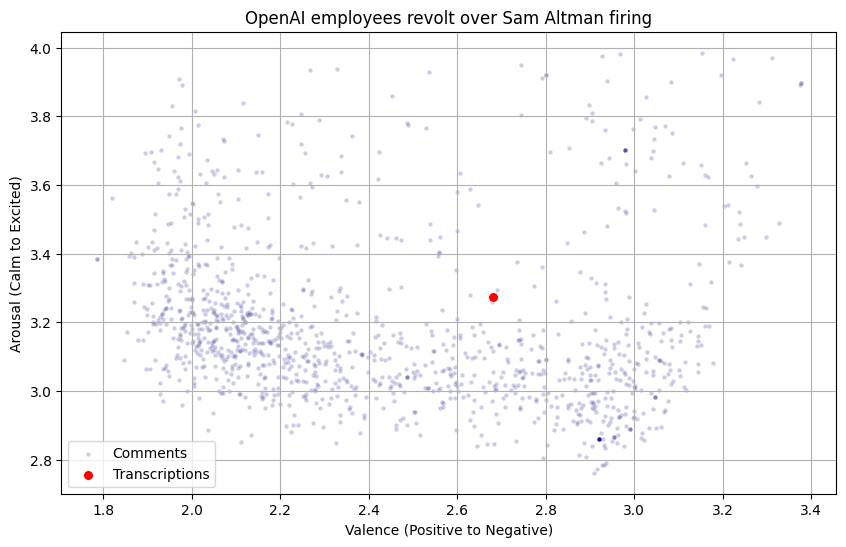

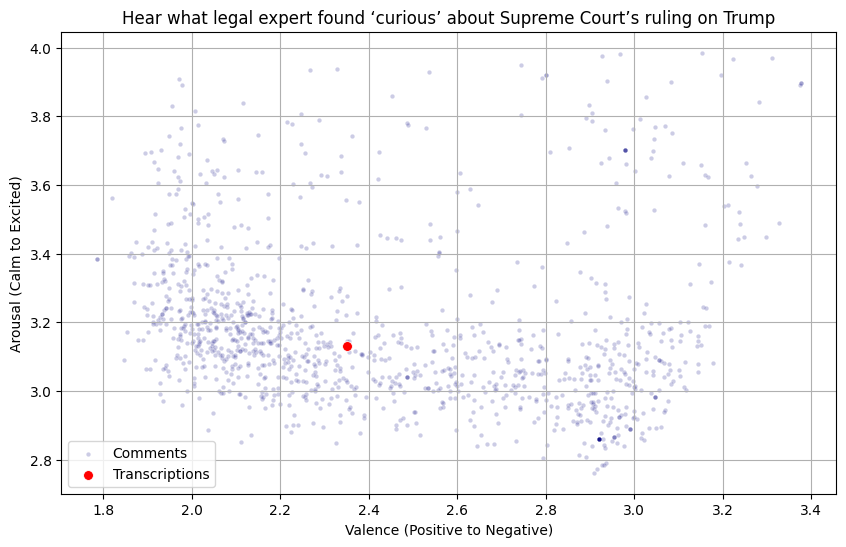

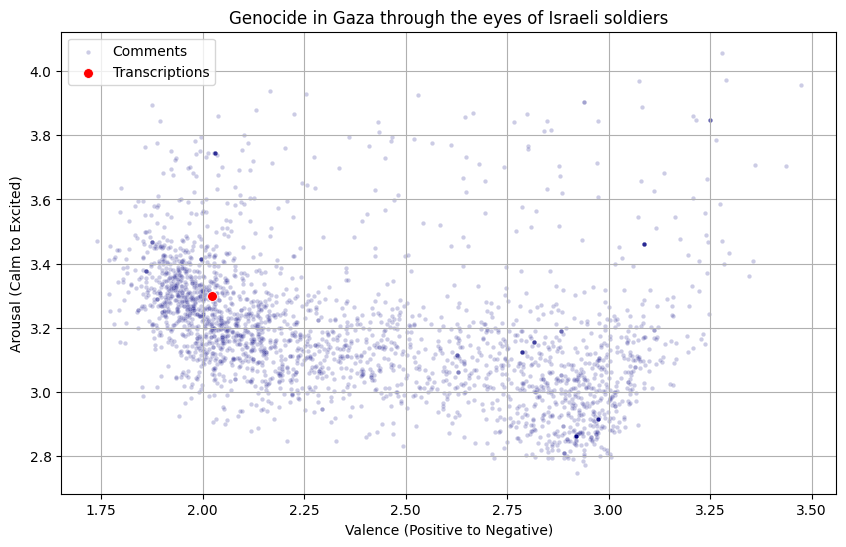

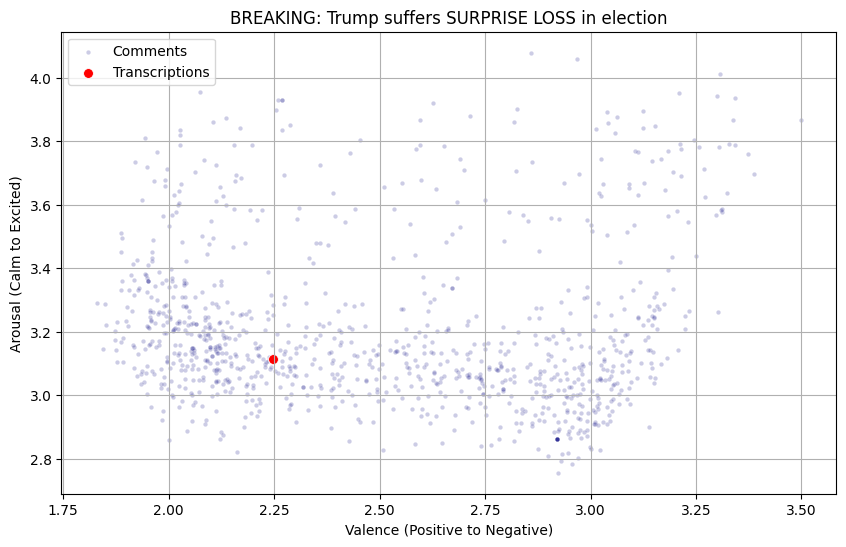

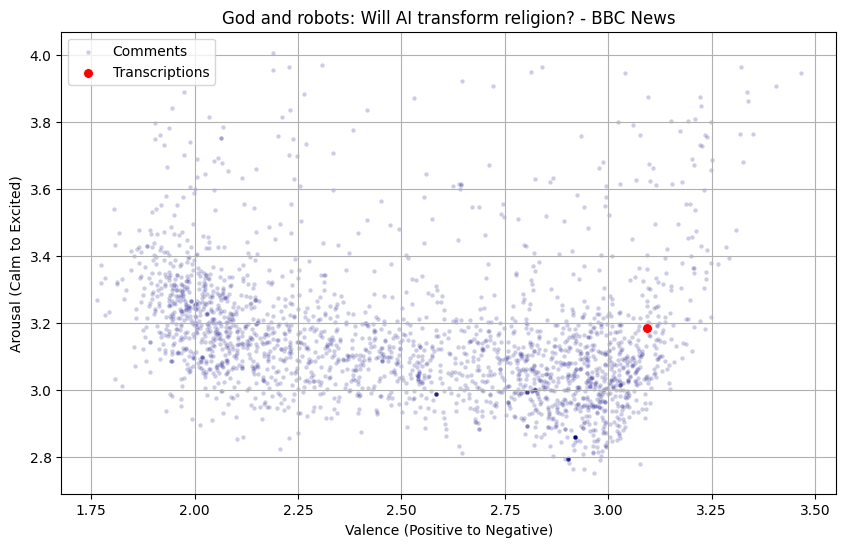

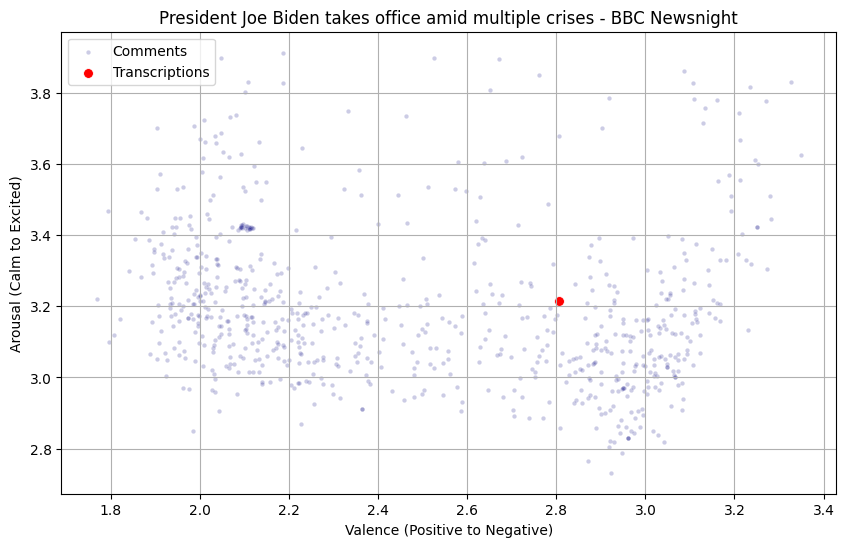

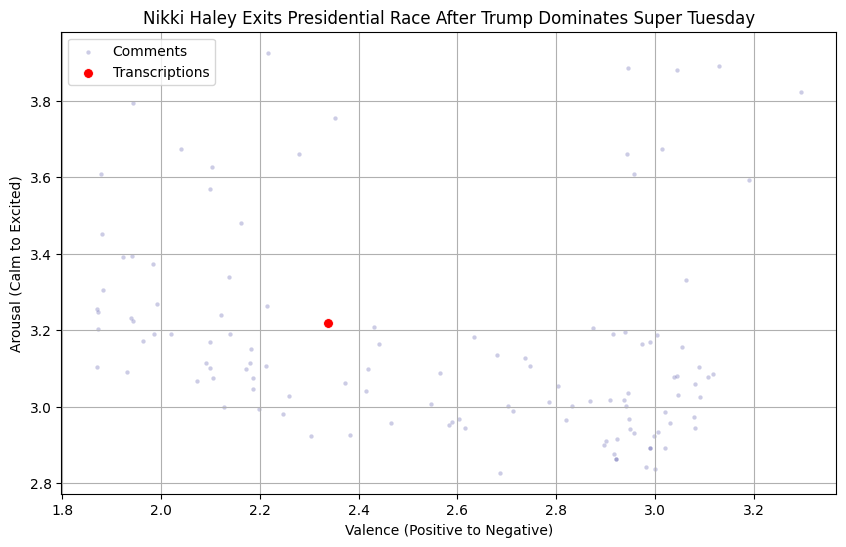

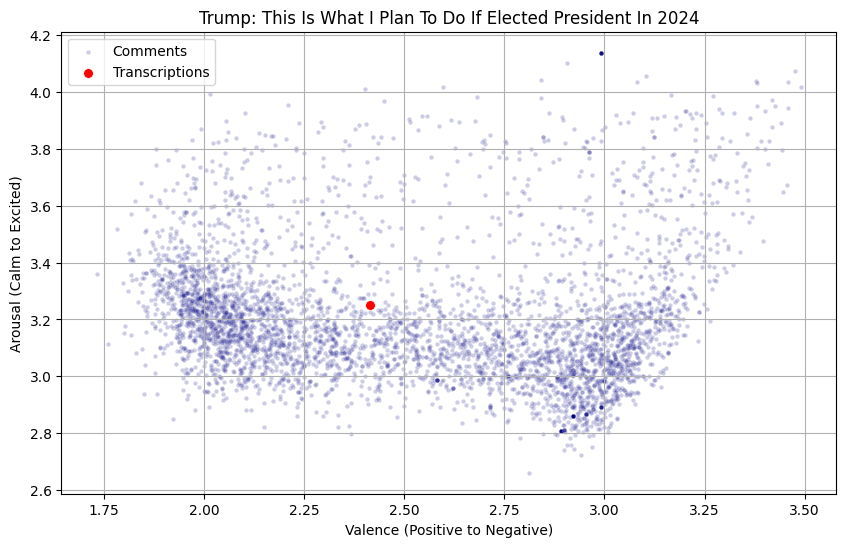

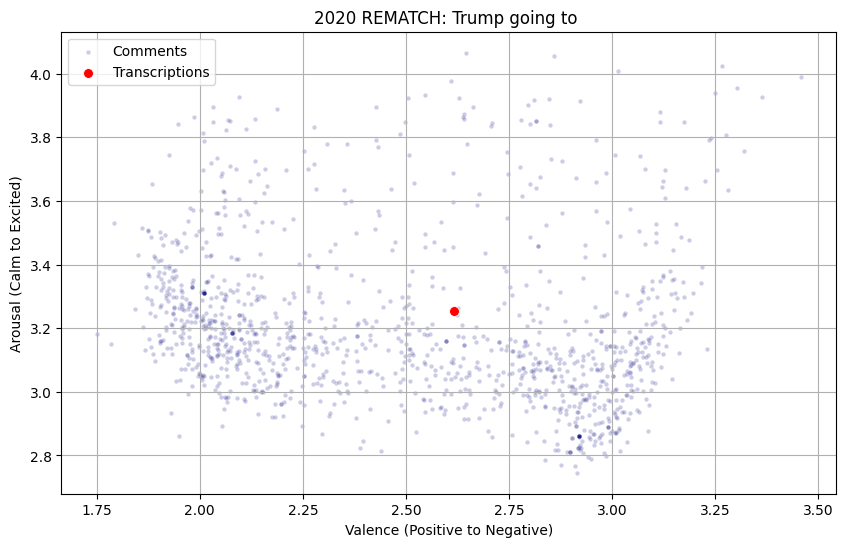

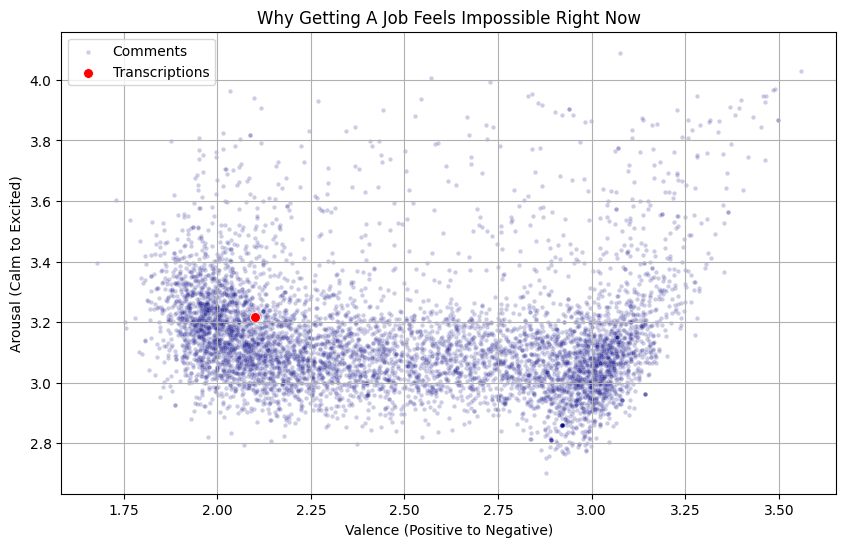

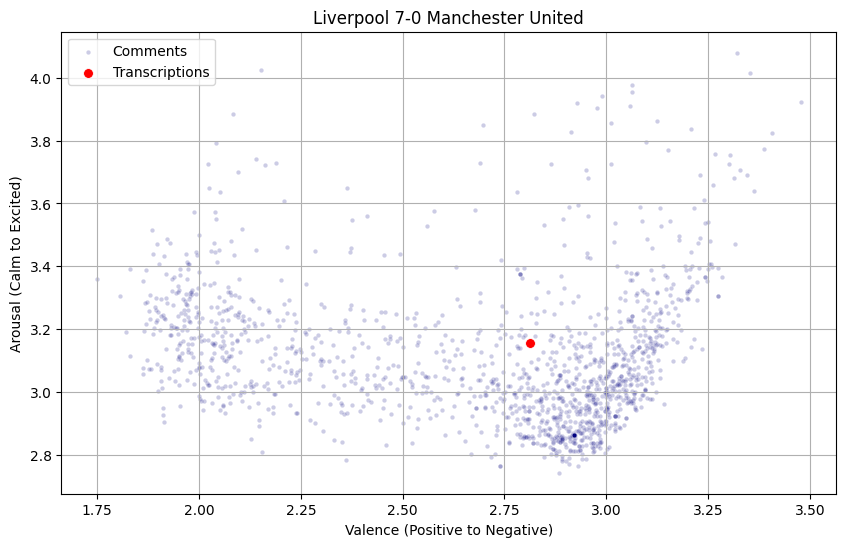

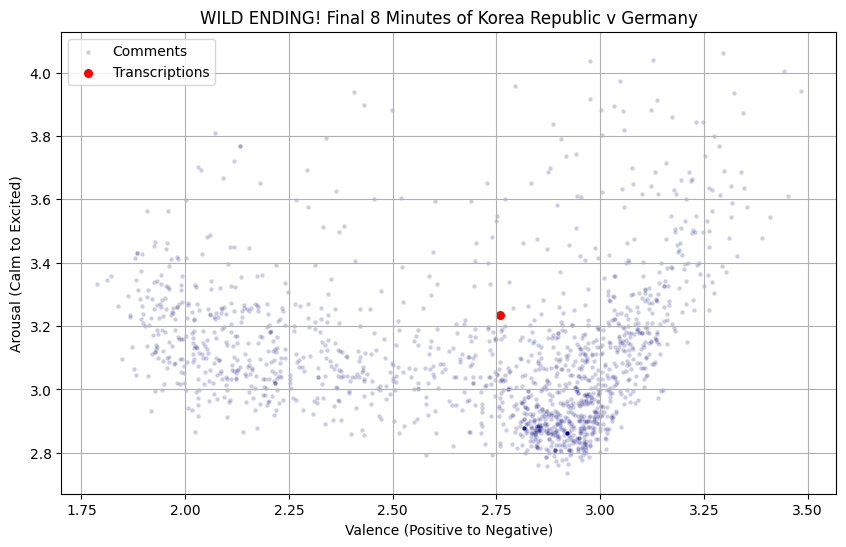

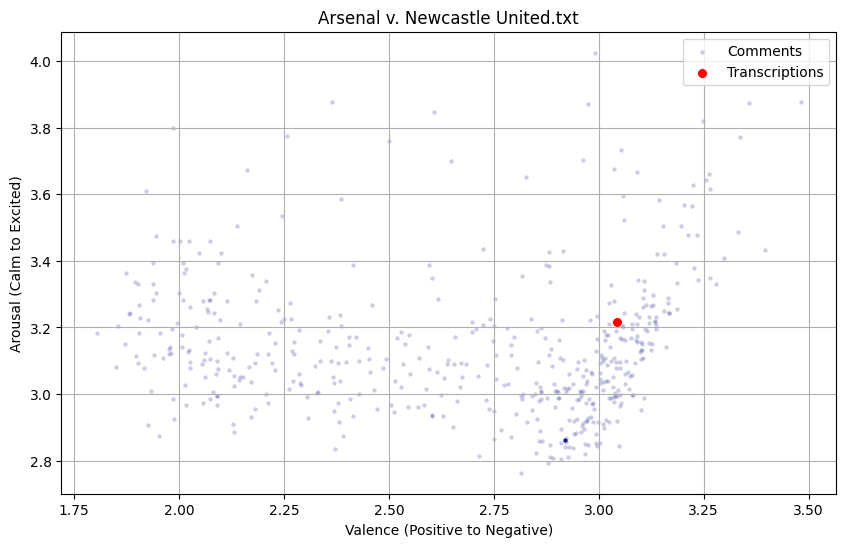

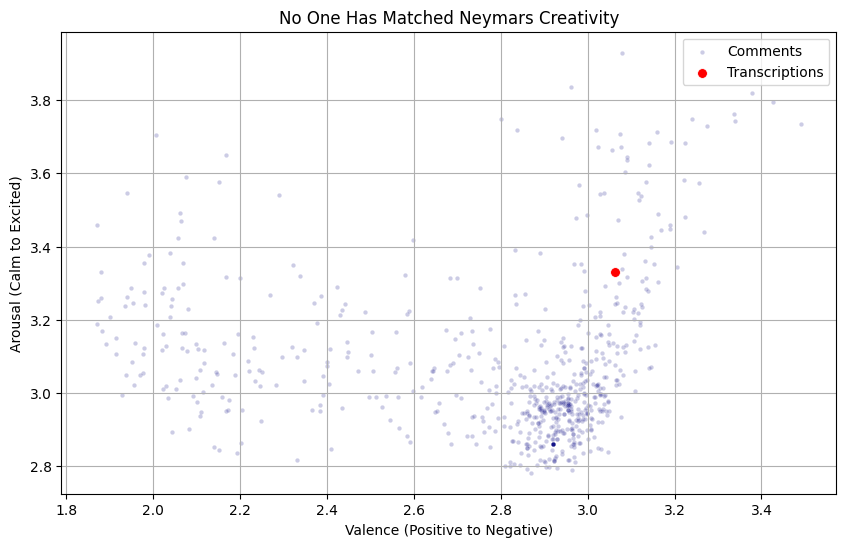

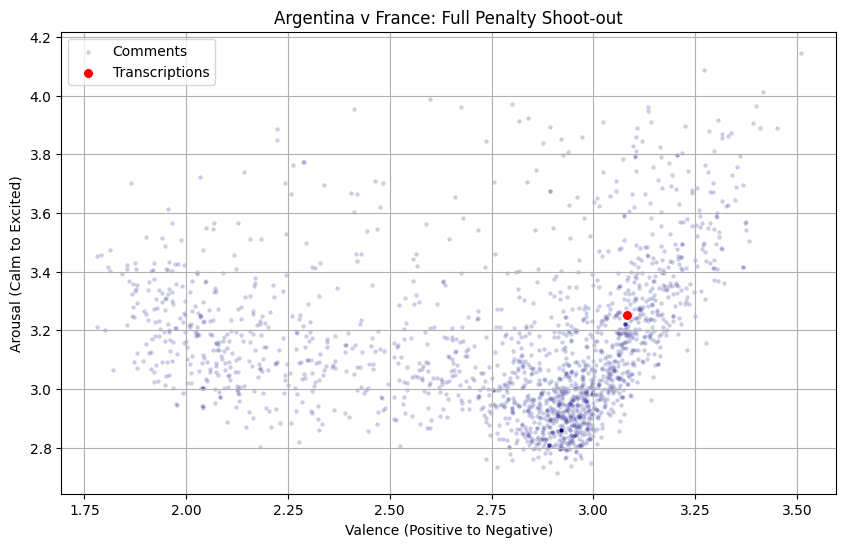

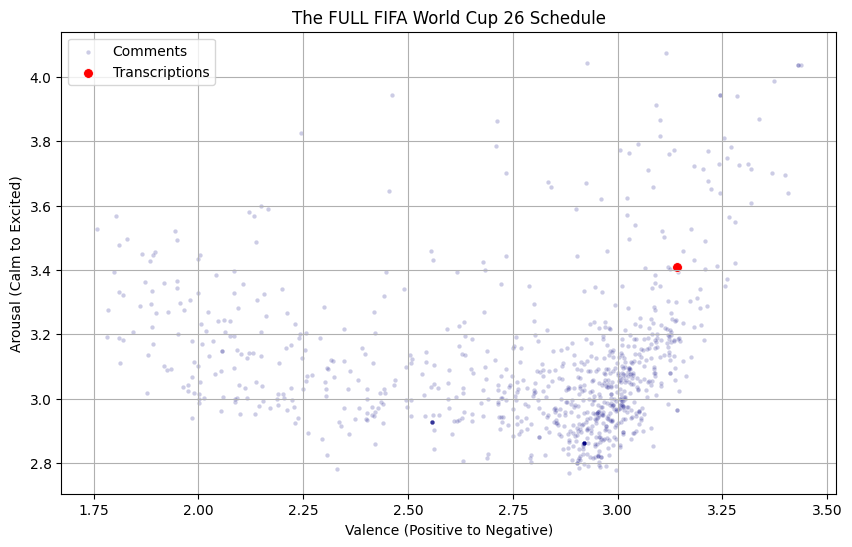

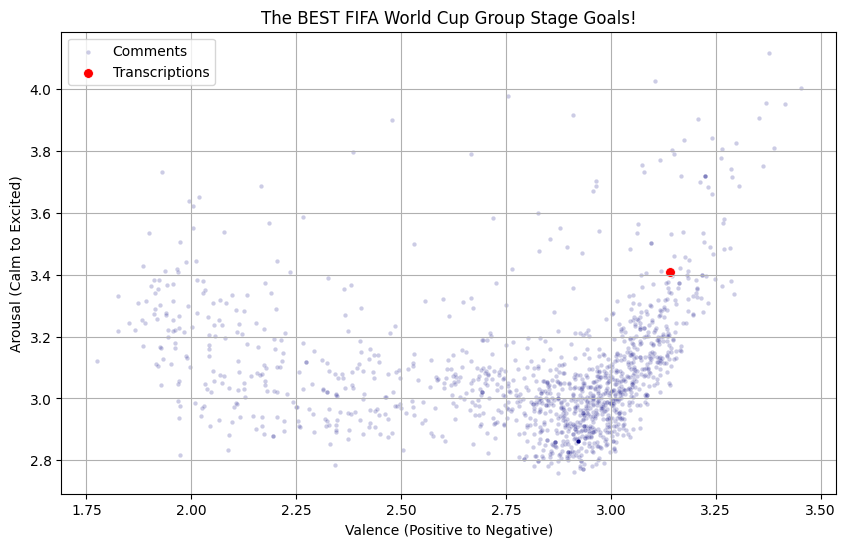

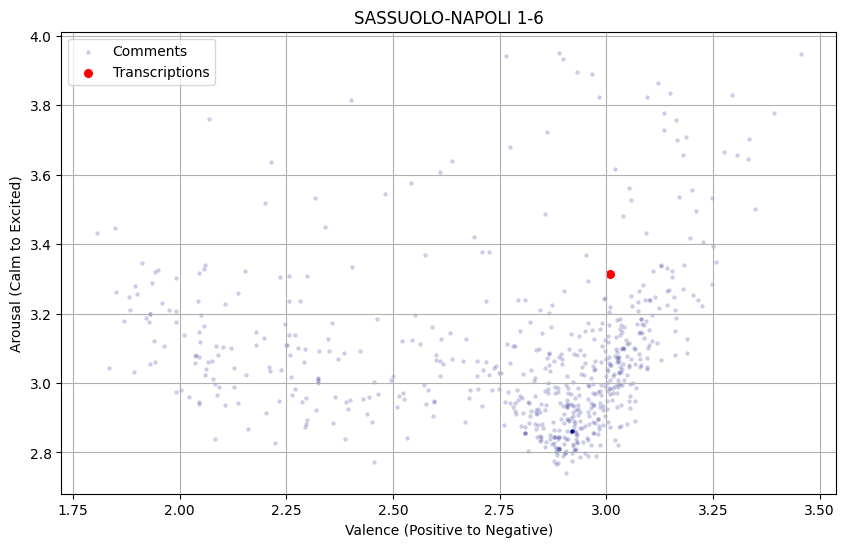

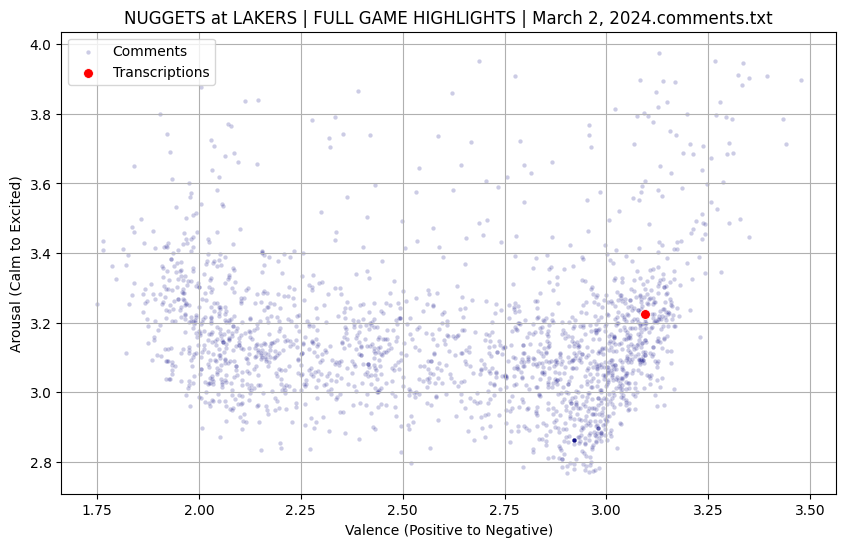

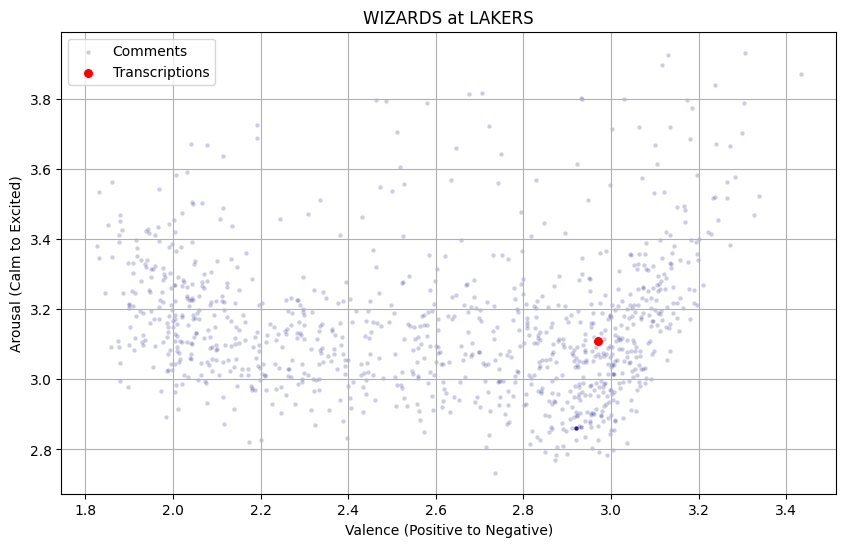

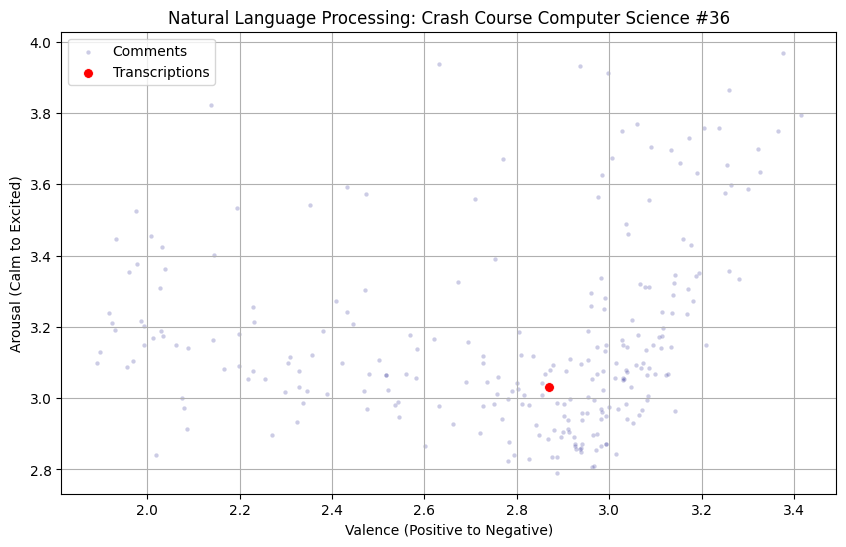

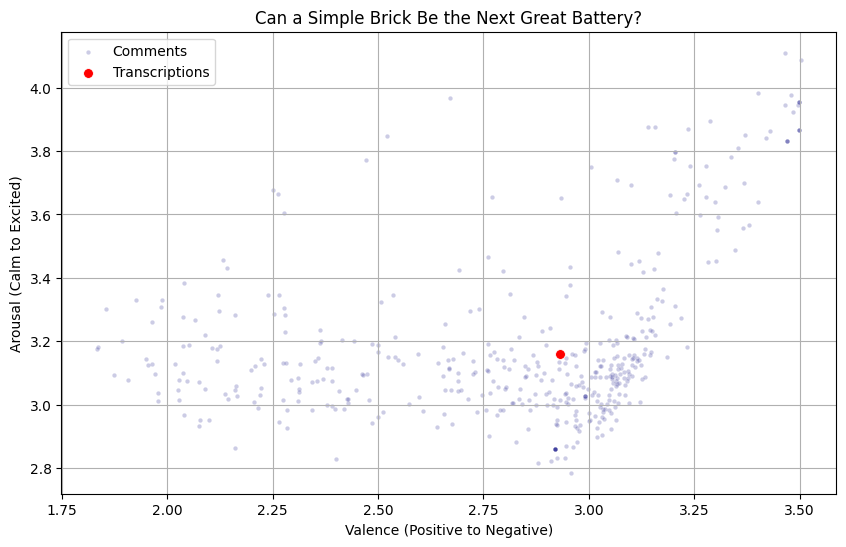

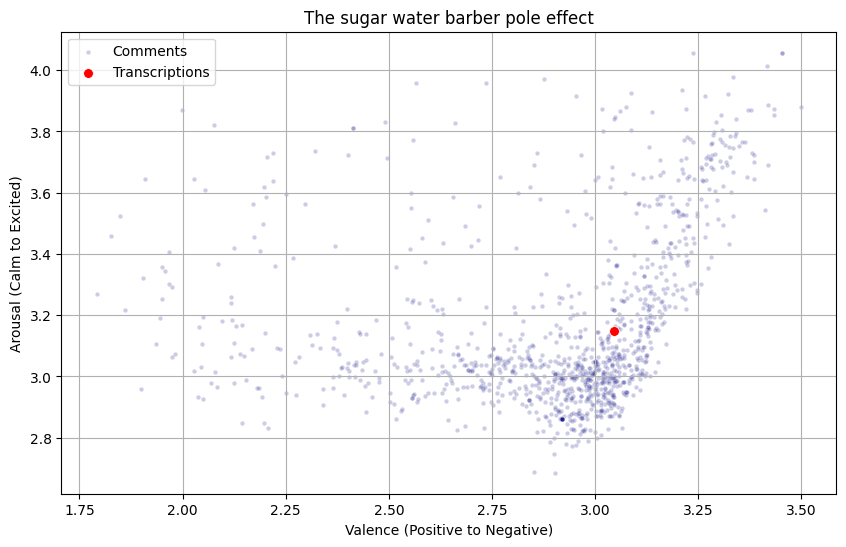

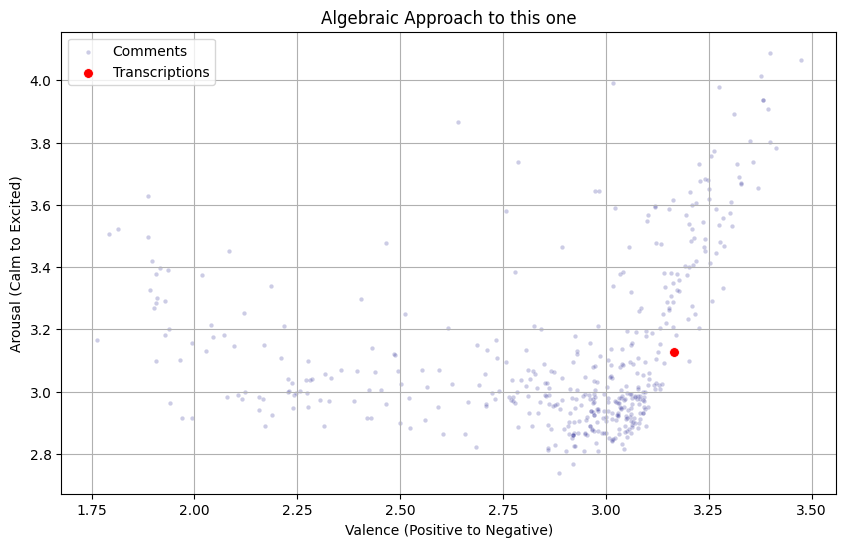

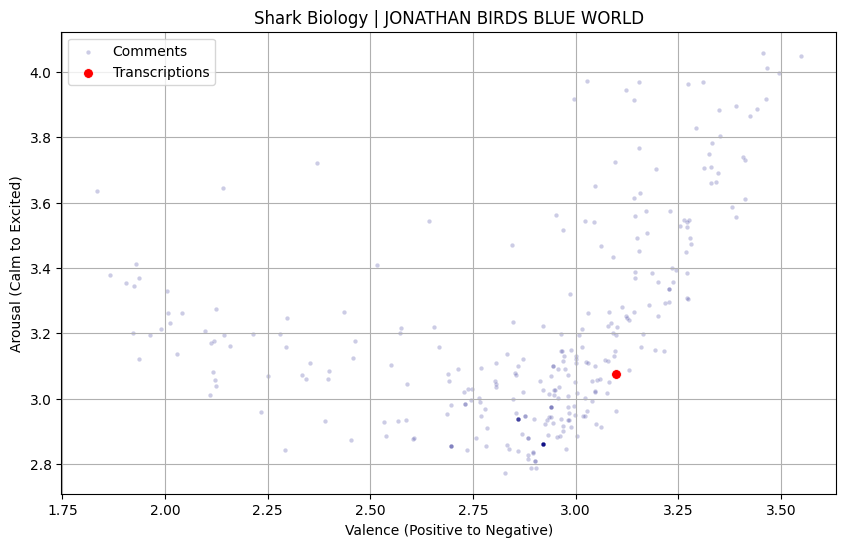

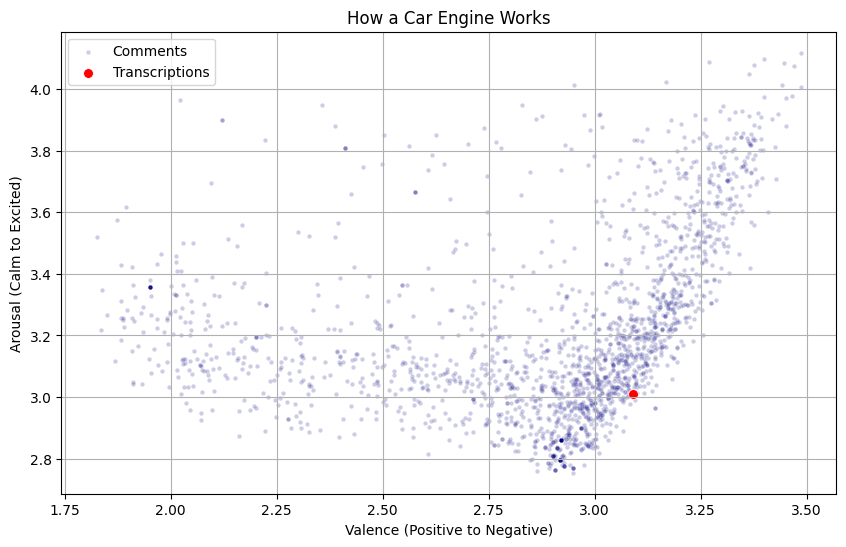

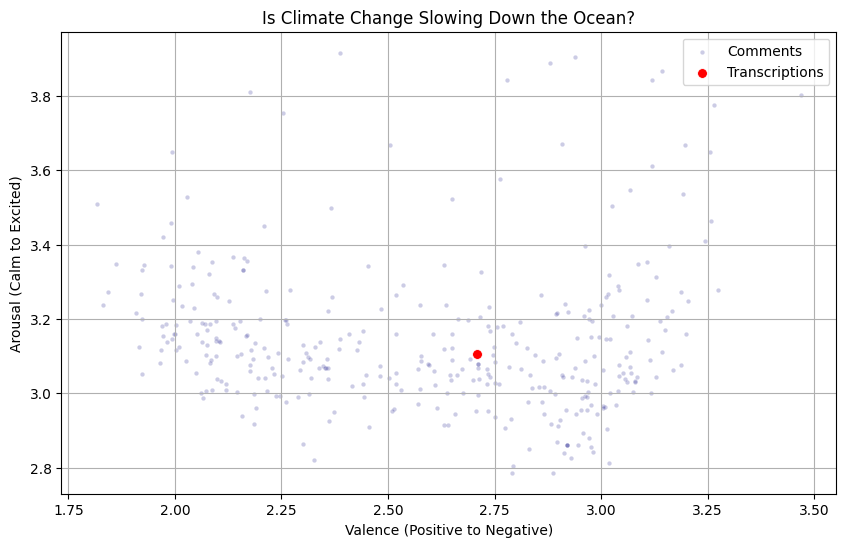

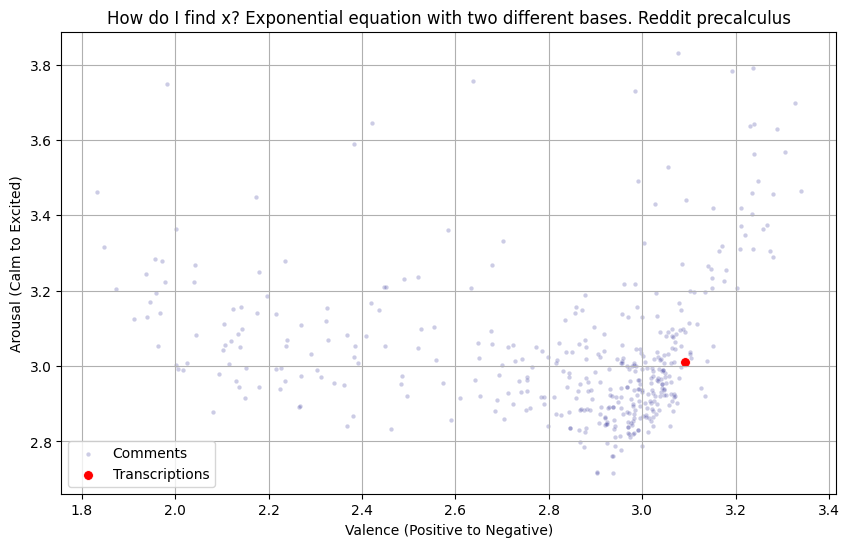

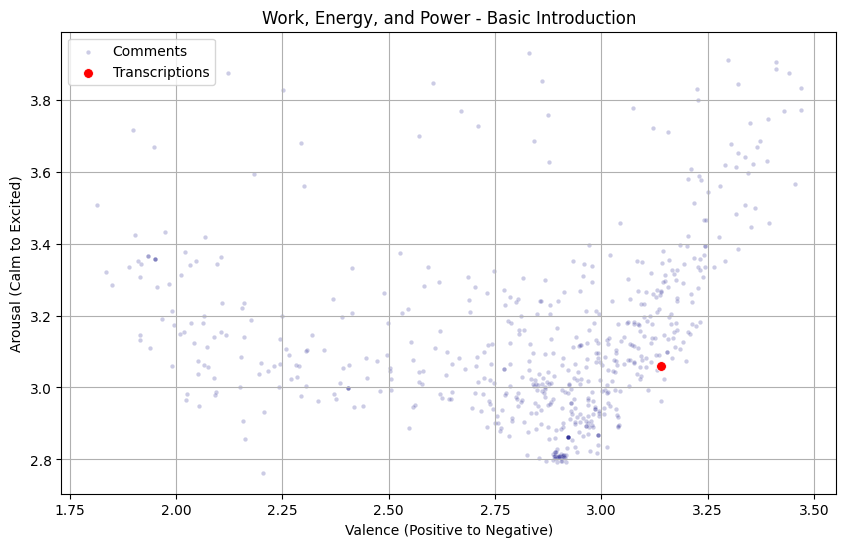

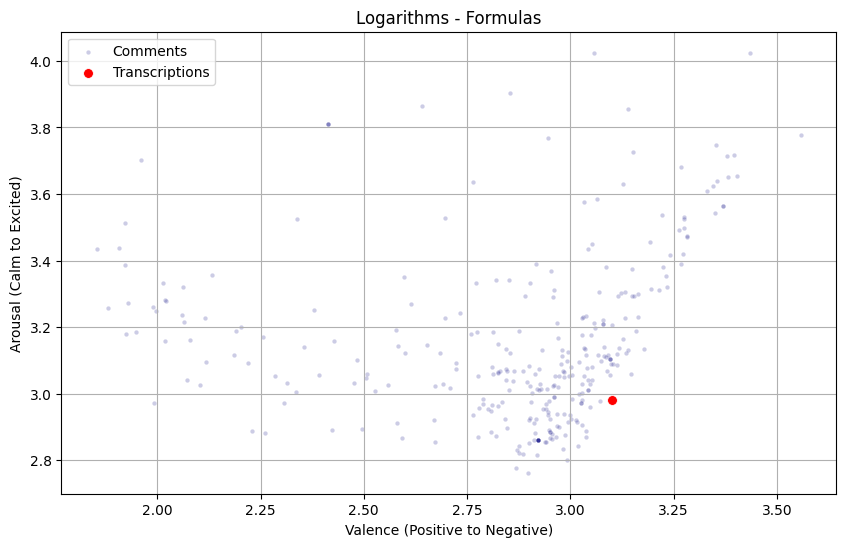

In [250]:
def plot_valence_arousal(comment_dir, transcription_dir):
    comment_csv_files = [f for f in os.listdir(comment_dir) if f.endswith('.csv')]
    for index, comment_file_name in enumerate(comment_csv_files):
        if index >= 10:  
            break
        comment_file_path = os.path.join(comment_dir, comment_file_name)
        comment_df = pd.read_csv(comment_file_path)
    
        transcription_file_name = [f for f in os.listdir(transcription_dir) if f.startswith(comment_file_name[:3]) and f.endswith('.csv')]
        if not transcription_file_name:
            continue
        
        transcription_file_path = os.path.join(transcription_dir, transcription_file_name[0])
        transcription_df = pd.read_csv(transcription_file_path)
    
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=comment_df, x='Valence', y='Arousal', alpha=0.2, color='navy', label='Comments', s=10)
        sns.scatterplot(data=transcription_df, x='Valence', y='Arousal', alpha=1, color='red', label='Transcriptions', s=50)
        plt.title(comment_file_name.replace("_scores.csv", ""))
        plt.xlabel('Valence (Positive to Negative)')
        plt.ylabel('Arousal (Calm to Excited)')
        plt.legend()
        plt.grid(True)
        plt.show()  

# Directory paths for the datasets
datasets = [
    ('/Users/heyodogo/Documents/projectfiles/news/news_comments_score', '/Users/heyodogo/Documents/projectfiles/news/news_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score', '/Users/heyodogo/Documents/projectfiles/sports/sports_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores', '/Users/heyodogo/Documents/projectfiles/learning/learning_transcriptions_scores')
]

# Process each dataset
for comments_path, transcriptions_path in datasets:
    plot_valence_arousal(comments_path, transcriptions_path)


# Visualizing specific videos that highlight the 3 distinct domains' differences

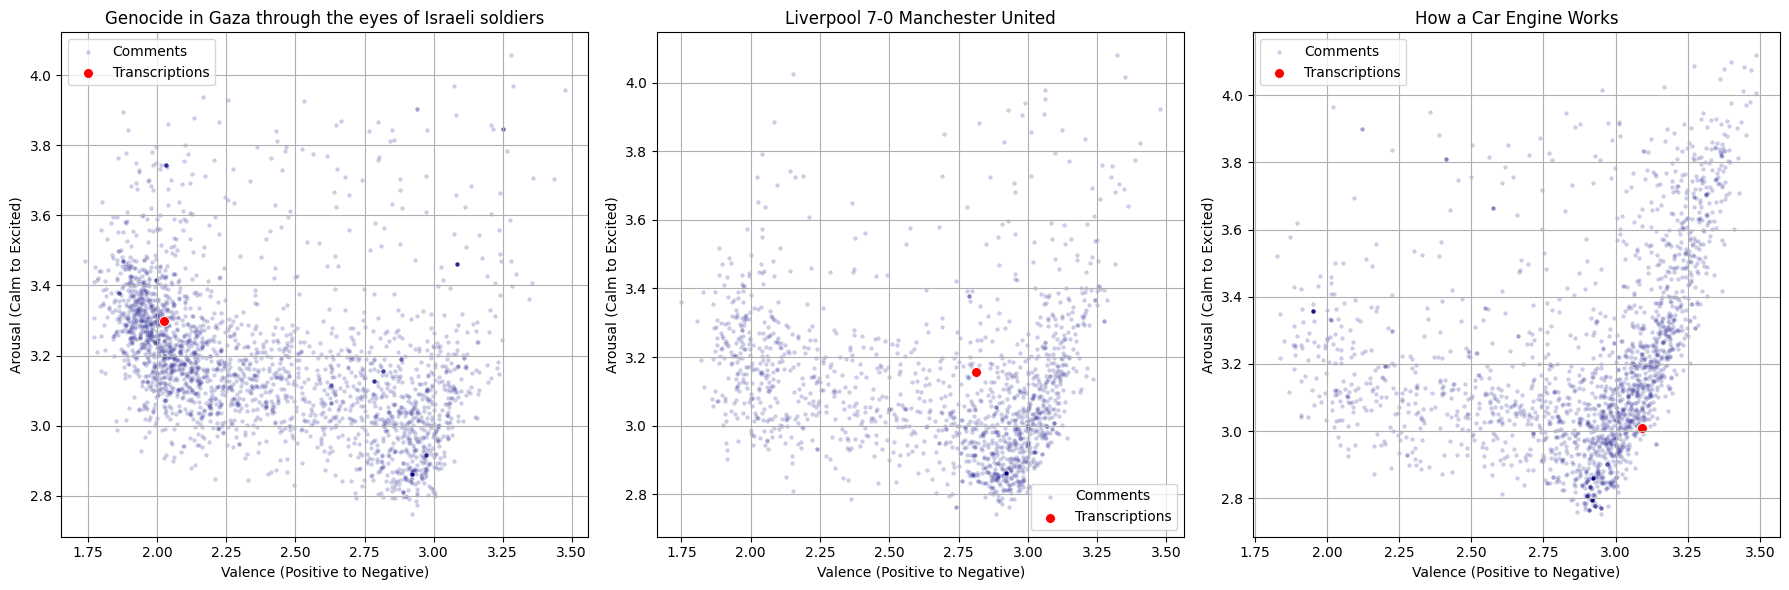

In [252]:
def get_files_from_directory(directory_path, file_suffix):
    return [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(file_suffix)]

def plot_valence_arousal(files_info, ax):
    comment_file_path, transcription_file_path = files_info
    comment_df = pd.read_csv(comment_file_path)
    transcription_df = pd.read_csv(transcription_file_path)
    
    # Plotting
    sns.scatterplot(data=comment_df, x='Valence', y='Arousal', alpha=0.2, color='navy', label='Comments', s=10, ax=ax)
    sns.scatterplot(data=transcription_df, x='Valence', y='Arousal', alpha=1, color='red', label='Transcriptions', s=50, ax=ax)
    ax.set_title(os.path.basename(comment_file_path).replace("_scores.csv", ""))
    ax.set_xlabel('Valence (Positive to Negative)')
    ax.set_ylabel('Arousal (Calm to Excited)')
    ax.legend()
    ax.grid(True)

# Directory paths for the datasets
datasets = [
    ('/Users/heyodogo/Documents/projectfiles/news/news_comments_score', '/Users/heyodogo/Documents/projectfiles/news/news_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score', '/Users/heyodogo/Documents/projectfiles/sports/sports_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores', '/Users/heyodogo/Documents/projectfiles/learning/learning_transcriptions_scores')
]

all_comment_files = []
all_transcription_files = []

# Gather all files from all directories
for comments_path, transcriptions_path in datasets:
    all_comment_files += get_files_from_directory(comments_path, '.csv')
    all_transcription_files += get_files_from_directory(transcriptions_path, '.csv')

# Sorting files to maintain a consistent order
all_comment_files.sort()
all_transcription_files.sort()

# Set up figure for horizontal subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 3 subplots
selected_indices = [12, 22, 2]  # Indices for 3rd, 13th, and 23rd plots

for idx, plot_index in enumerate(selected_indices):
    if plot_index < len(all_comment_files) and plot_index < len(all_transcription_files):
        plot_valence_arousal((all_comment_files[plot_index], all_transcription_files[plot_index]), axes[idx])

plt.tight_layout()
plt.show()


# Plotting all of the comments and transcriptions score together in their respective domain

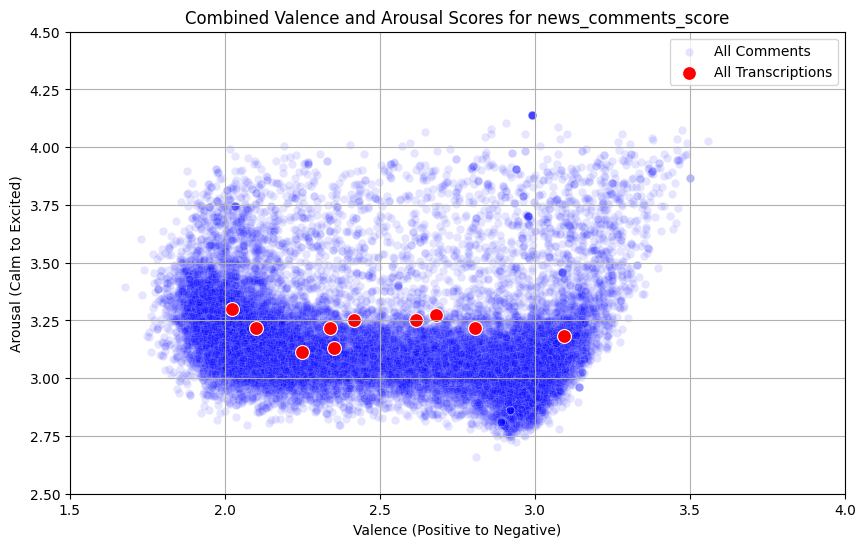

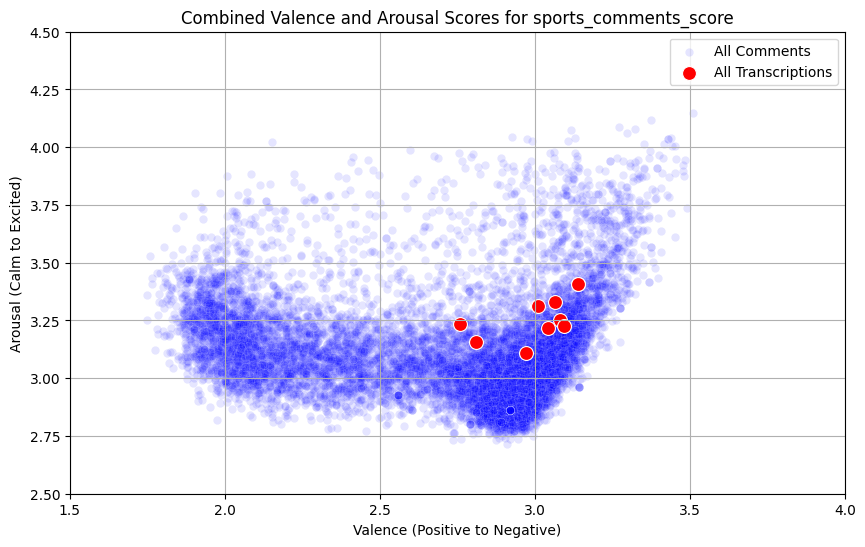

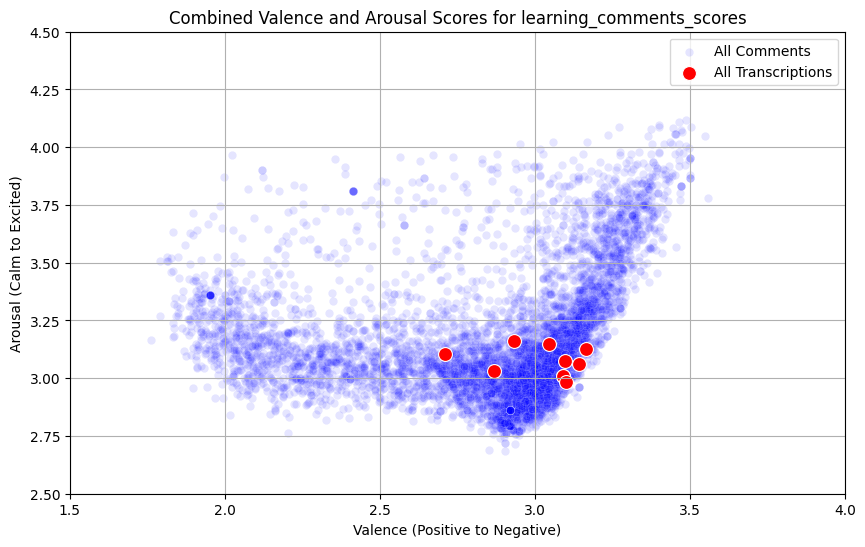

In [224]:
def plot_combined_valence_arousal(comment_dir, transcription_dir):
    comment_csv_files = [f for f in os.listdir(comment_dir) if f.endswith('.csv')]
    
    all_comments = pd.DataFrame()
    all_transcriptions = pd.DataFrame()
    
    for comment_file_name in comment_csv_files:
        comment_file_path = os.path.join(comment_dir, comment_file_name)
        comment_df = pd.read_csv(comment_file_path)
        all_comments = pd.concat([all_comments, comment_df], ignore_index=True)
        
        transcription_file_name = [f for f in os.listdir(transcription_dir) if f.startswith(comment_file_name[:3]) and f.endswith('.csv')]
        if transcription_file_name:
            transcription_file_path = os.path.join(transcription_dir, transcription_file_name[0])
            transcription_df = pd.read_csv(transcription_file_path)
            
            all_transcriptions = pd.concat([all_transcriptions, transcription_df], ignore_index=True)
    
    # Create a single plot with all data
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=all_comments, x='Valence', y='Arousal', alpha=0.1, color='blue', label='All Comments')
    sns.scatterplot(data=all_transcriptions, x='Valence', y='Arousal', alpha=1, color='red', label='All Transcriptions', s = 100)
    plt.title(f"Combined Valence and Arousal Scores for {os.path.basename(comment_dir)}")
    plt.xlabel('Valence (Positive to Negative)')
    plt.ylabel('Arousal (Calm to Excited)')
    plt.ylim(2.5, 4.5)
    plt.xlim(1.5, 4)
    plt.legend()
    plt.grid(True)
    plt.show()

# Directory paths for the datasets
datasets = [
    ('/Users/heyodogo/Documents/projectfiles/news/news_comments_score', '/Users/heyodogo/Documents/projectfiles/news/news_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score', '/Users/heyodogo/Documents/projectfiles/sports/sports_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores', '/Users/heyodogo/Documents/projectfiles/learning/learning_transcriptions_scores')
]

# Process each dataset
for comments_path, transcriptions_path in datasets:
    plot_combined_valence_arousal(comments_path, transcriptions_path)


# Visualize sentiment density across News, Sports, and Learning domains from YouTube data.

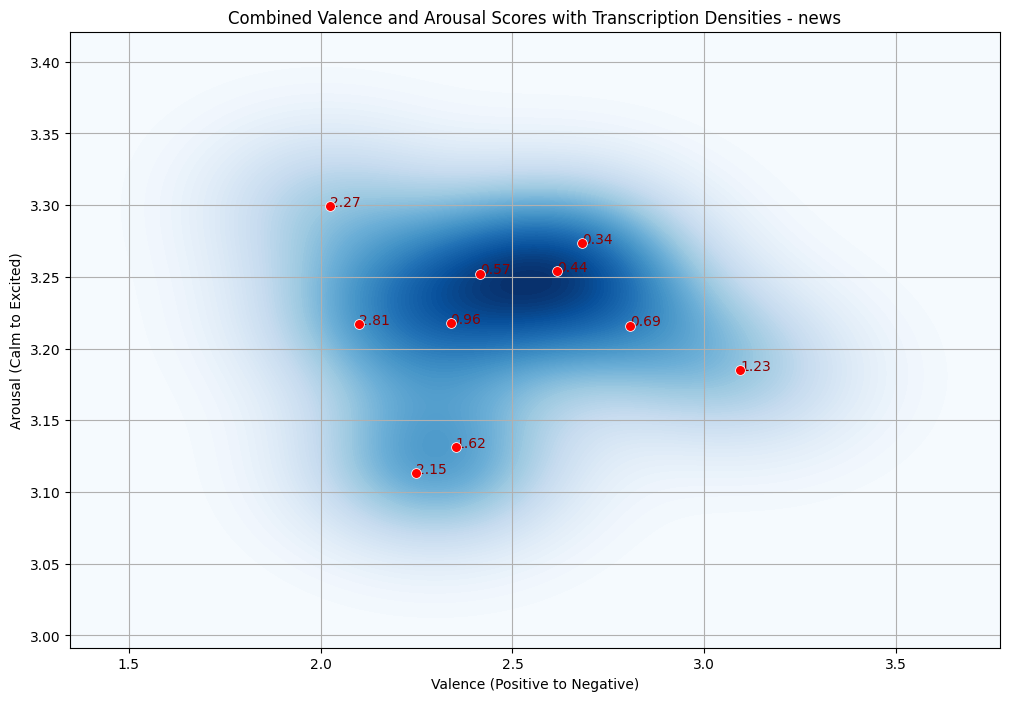

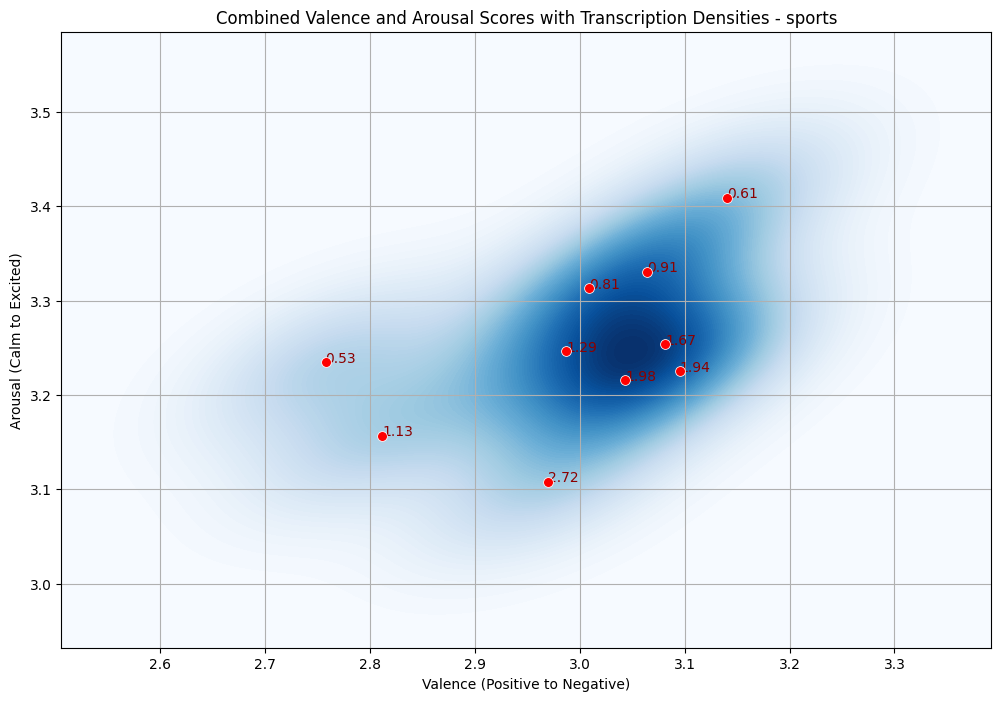

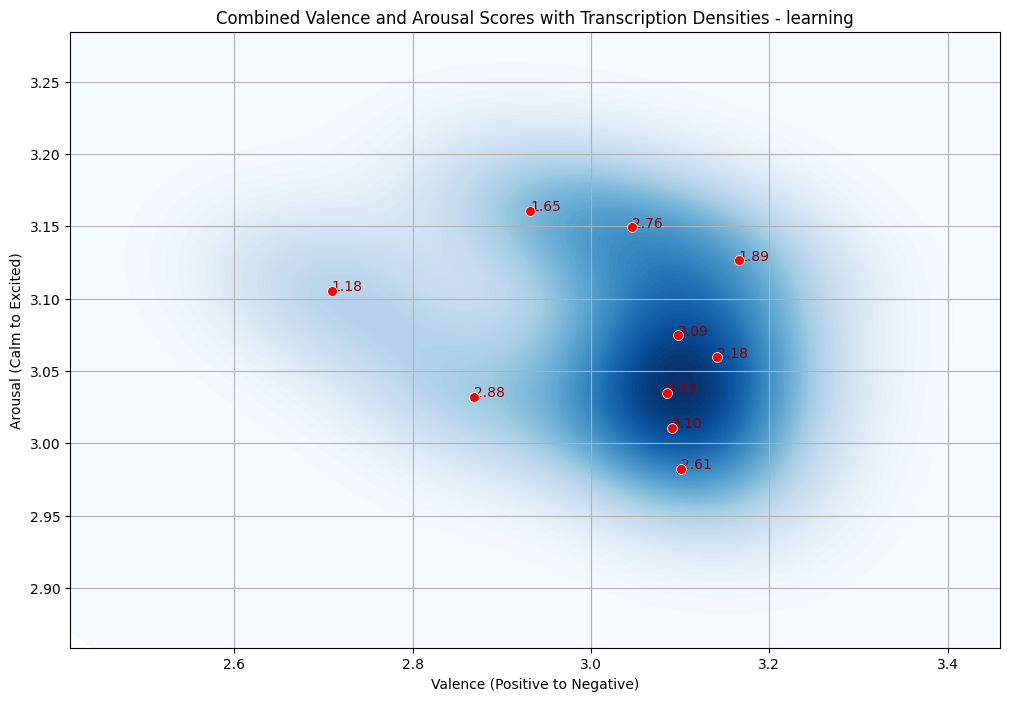

In [259]:
from scipy.stats import gaussian_kde

def calculate_point_density(comments_path, transcriptions_path):
    comment_csv_files = [os.path.join(comments_path, f) for f in os.listdir(comments_path) if f.endswith('.csv')]
    all_comments = pd.concat([pd.read_csv(f) for f in comment_csv_files], ignore_index=True)

    transcription_csv_files = [os.path.join(transcriptions_path, f) for f in os.listdir(transcriptions_path) if f.endswith('.csv')]
    all_transcriptions = pd.concat([pd.read_csv(f) for f in transcription_csv_files], ignore_index=True)
    if 'Valence' in all_comments.columns and 'Arousal' in all_comments.columns:
        kde = gaussian_kde(all_comments[['Valence', 'Arousal']].T)
        transcriptions_kde_values = kde(all_transcriptions[['Valence', 'Arousal']].T)
        all_transcriptions['Density'] = transcriptions_kde_values

    return all_transcriptions[['Valence', 'Arousal', 'Density']]

def visualize_point_densities(comments_path, transcriptions_path, domain_name):
    densities_df = calculate_point_density(comments_path, transcriptions_path)
    plt.figure(figsize=(12, 8))
    ax = sns.kdeplot(data=densities_df, x='Valence', y='Arousal', fill=True, thresh=0, levels=100, cmap='Blues')
    sns.scatterplot(data=densities_df, x='Valence', y='Arousal', color='red', s=50, ax=ax, zorder=5)
    for idx, row in densities_df.iterrows():
        ax.text(row['Valence'], row['Arousal'], f"{row['Density']:.2f}", color='darkred')
    plt.title(f'Combined Valence and Arousal Scores with Transcription Densities - {domain_name}')
    plt.xlabel('Valence (Positive to Negative)')
    plt.ylabel('Arousal (Calm to Excited)')
    plt.grid(True)
    plt.show()


datasets = [
    ('news', '/Users/heyodogo/Documents/projectfiles/news/news_comments_score', '/Users/heyodogo/Documents/projectfiles/news/news_transcriptions_scores'),
    ('sports', '/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score', '/Users/heyodogo/Documents/projectfiles/sports/sports_transcriptions_scores'),
    ('learning', '/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores', '/Users/heyodogo/Documents/projectfiles/learning/learning_transcriptions_scores')
]

for domain_name, comments_path, transcriptions_path in datasets:
    visualize_point_densities(comments_path, transcriptions_path, domain_name)


# Plot KDEs and transcription lines for sentiment scores across multiple YouTube content domains.

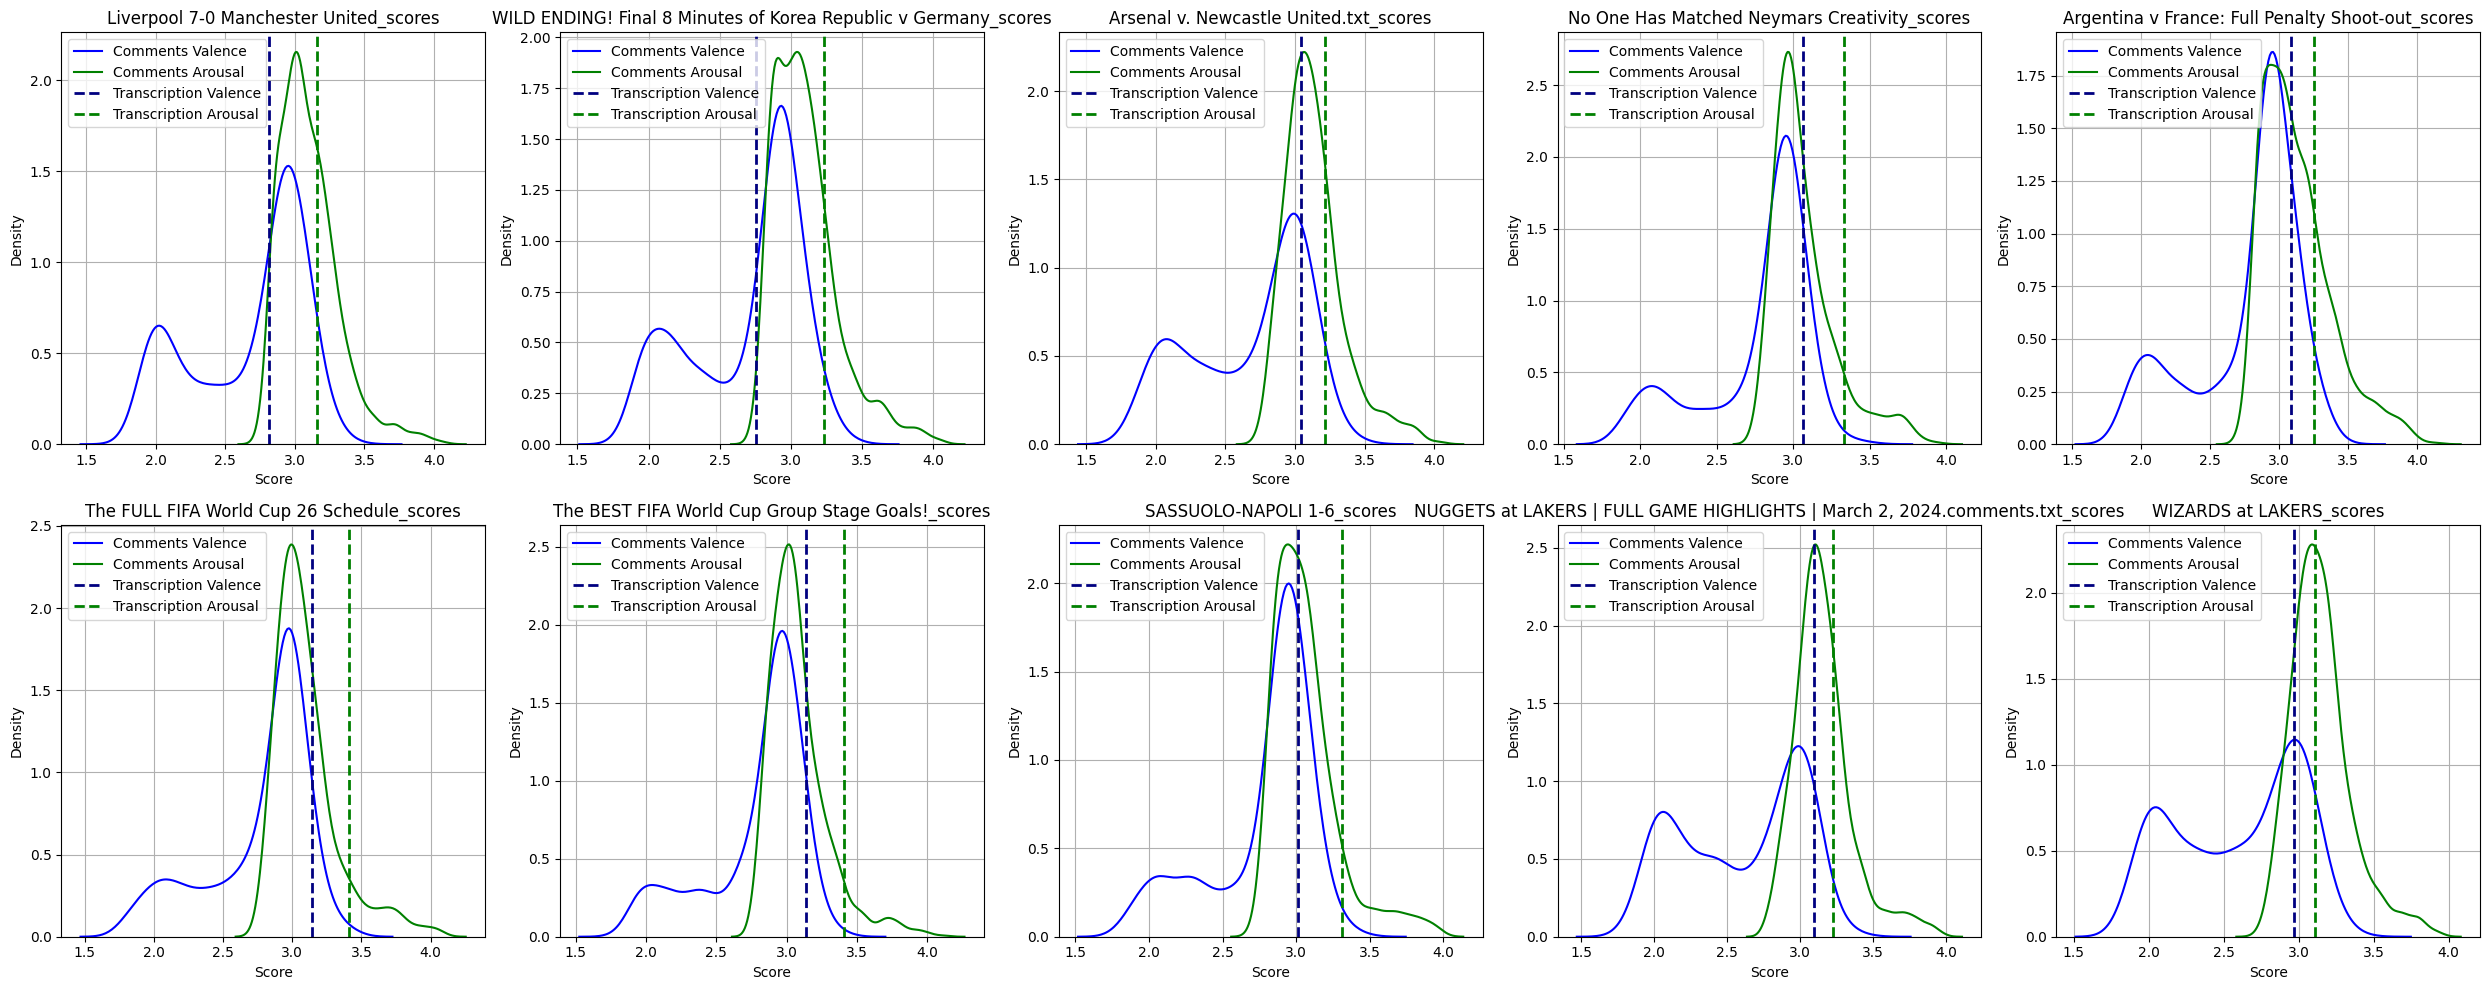

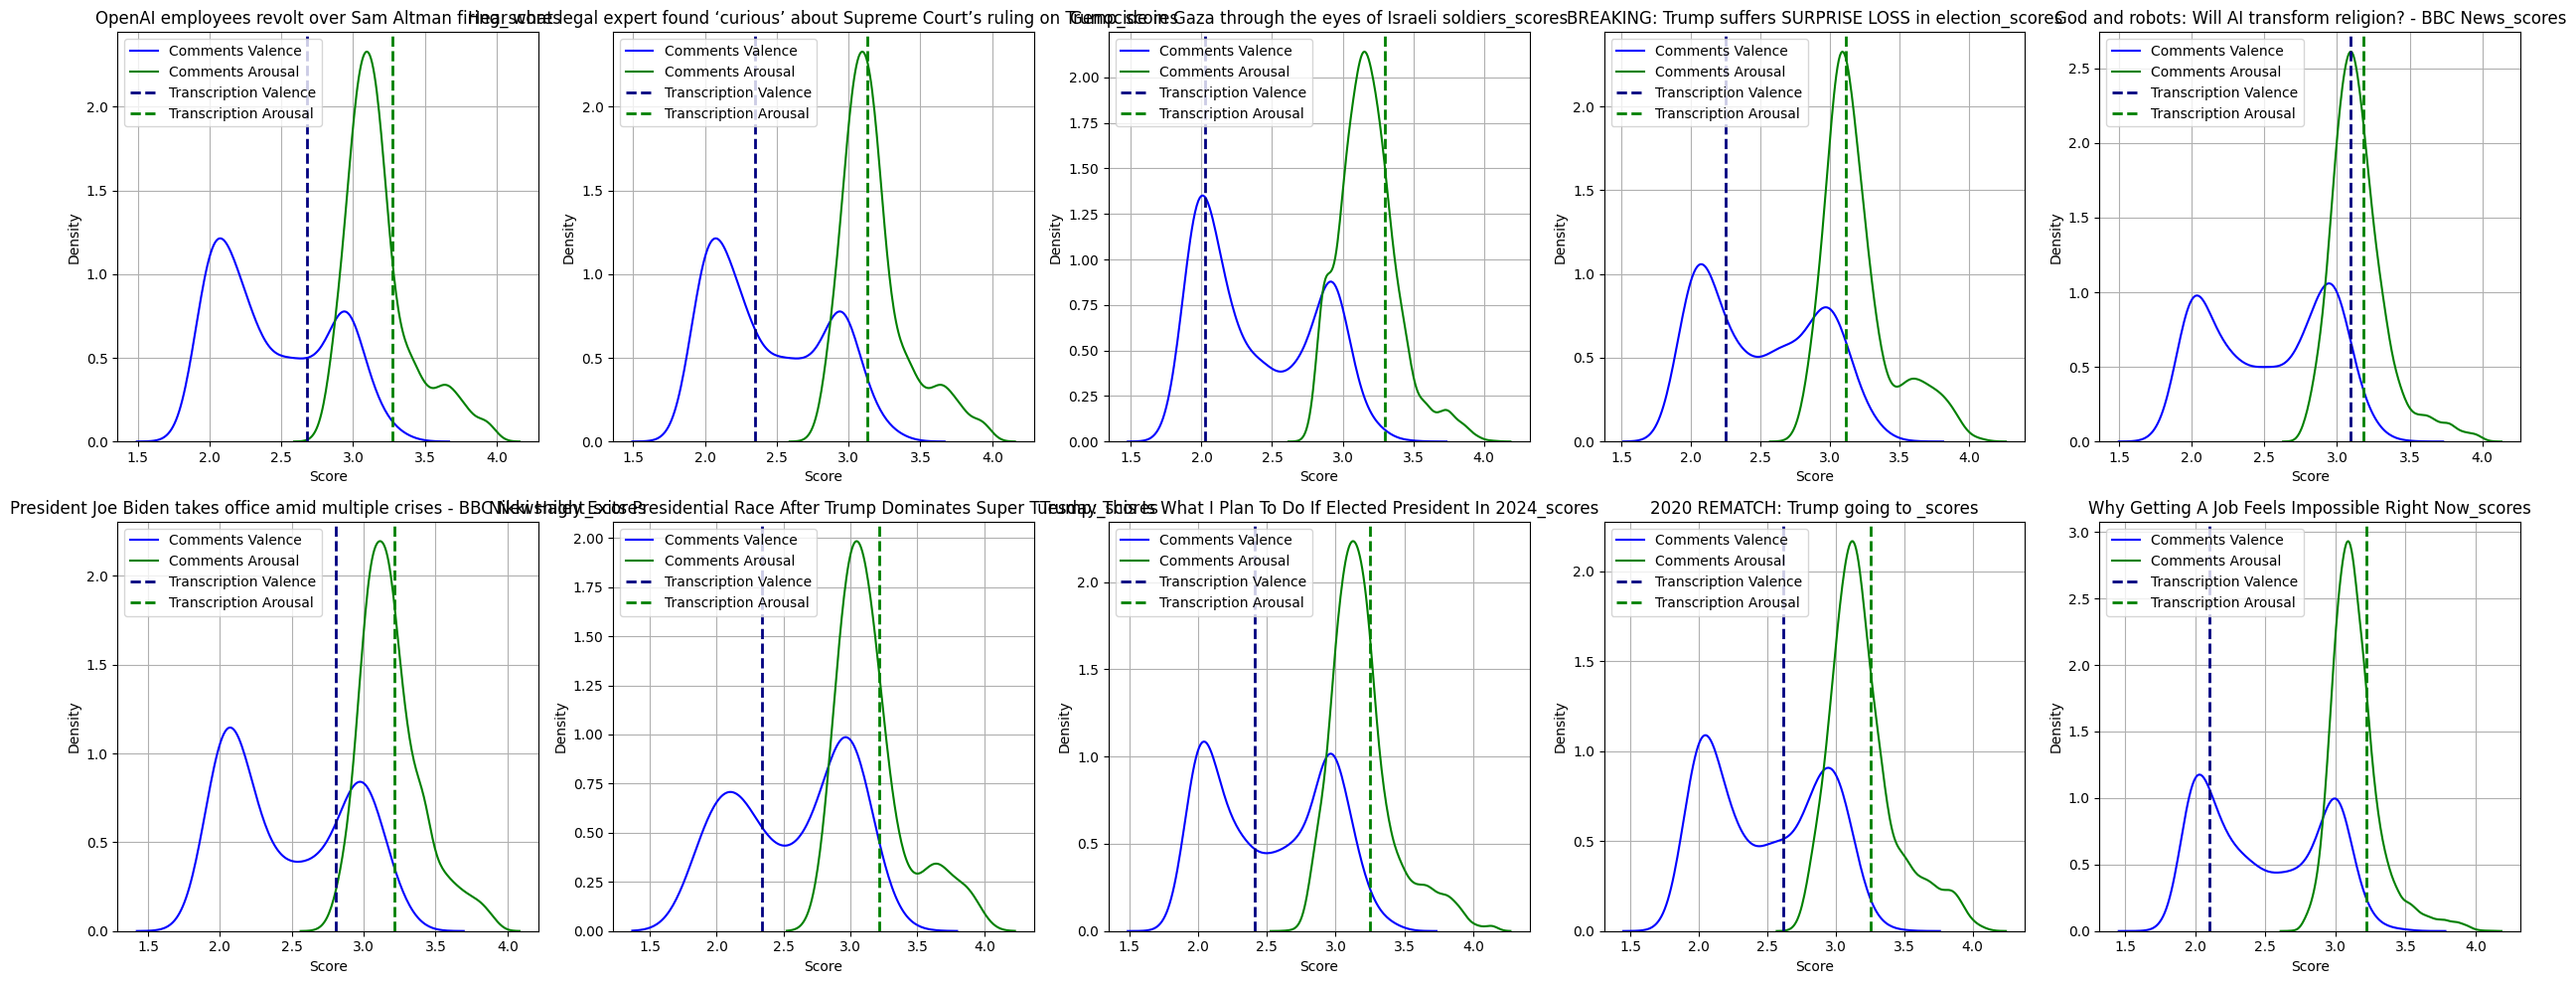

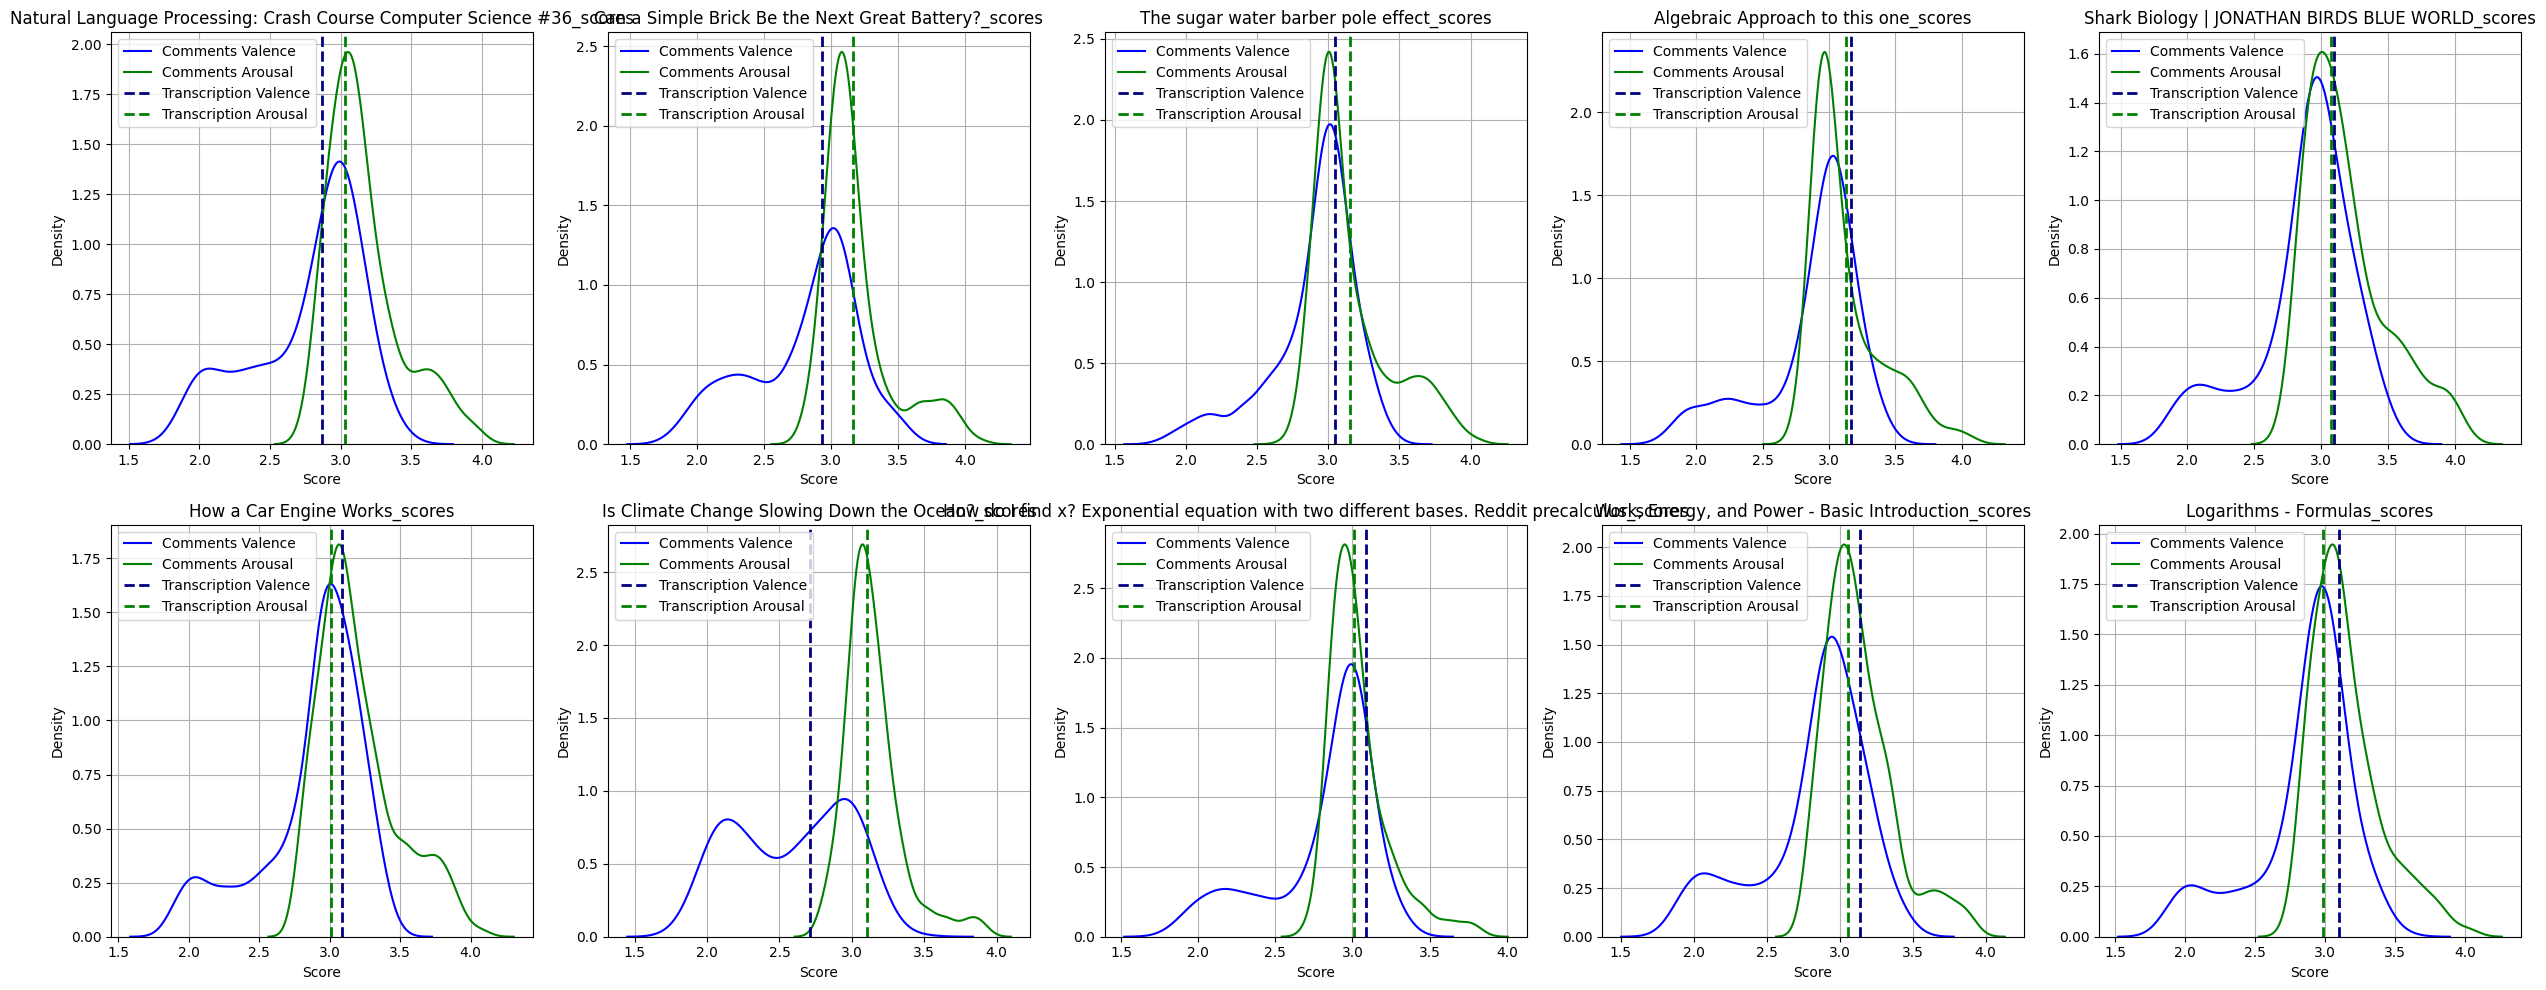

In [246]:
def plot_kde_and_lines(comment_dir, transcription_dir, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    axes = axes.flatten()

    comment_csv_files = [f for f in os.listdir(comment_dir) if f.endswith('.csv')]

    for index, comment_file_name in enumerate(comment_csv_files):
        if index >= len(axes): 
            break
        comment_file_path = os.path.join(comment_dir, comment_file_name)
        comment_df = pd.read_csv(comment_file_path)

        transcription_file_name = next((f for f in os.listdir(transcription_dir) if f.startswith(comment_file_name[:3]) and f.endswith('.csv')), None)
        if transcription_file_name:
            transcription_file_path = os.path.join(transcription_dir, transcription_file_name)
            transcription_df = pd.read_csv(transcription_file_path)

            ax = axes[index]
            if comment_df['Valence'].var() > 0:
                sns.kdeplot(data=comment_df, x='Valence', color='blue', label='Comments Valence', ax=ax)
            if comment_df['Arousal'].var() > 0:
                sns.kdeplot(data=comment_df, x='Arousal', color='green', label='Comments Arousal', ax=ax)

            # Plot transcription scores as vertical lines
            valence_transcription = transcription_df['Valence'].iloc[0]
            arousal_transcription = transcription_df['Arousal'].iloc[0]
            ax.axvline(x=valence_transcription, color='navy', linestyle='--', linewidth=2, label='Transcription Valence')
            ax.axvline(x=arousal_transcription, color='green', linestyle='--', linewidth=2, label='Transcription Arousal')
            ax.set_title(f'{comment_file_name[:-4]}')
            ax.set_xlabel('Score')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True)


    # Show plot
    plt.tight_layout()
    plt.show()


directory_paths = [
    ('/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score', '/Users/heyodogo/Documents/projectfiles/sports/sports_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/news/news_comments_score', '/Users/heyodogo/Documents/projectfiles/news/news_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores', '/Users/heyodogo/Documents/projectfiles/learning/learning_transcriptions_scores')
]

for comment_path, transcription_path in directory_paths:
    plot_kde_and_lines(comment_path, transcription_path, nrows=2, ncols=5)


# Visualize combined KDEs of comments with mean transcription lines for valence and arousal scores.

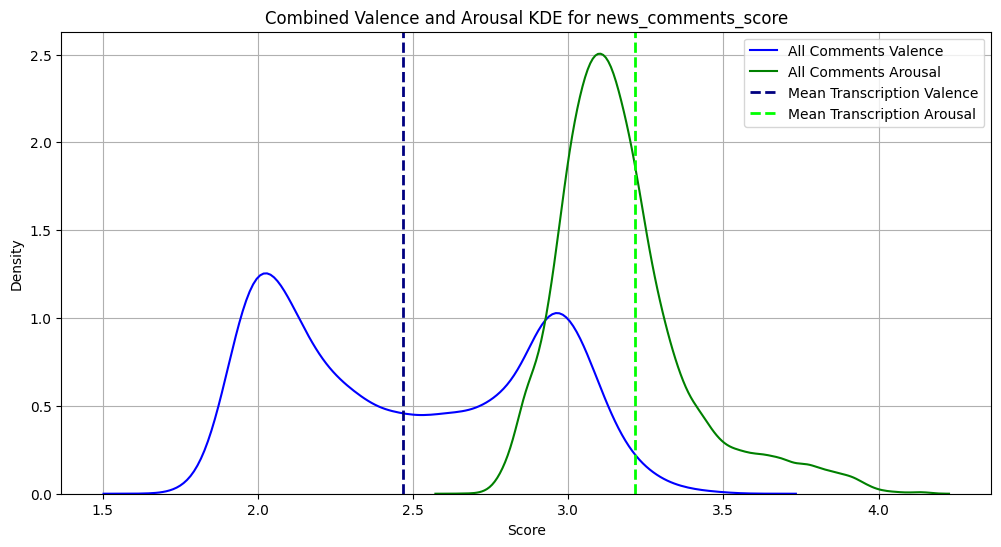

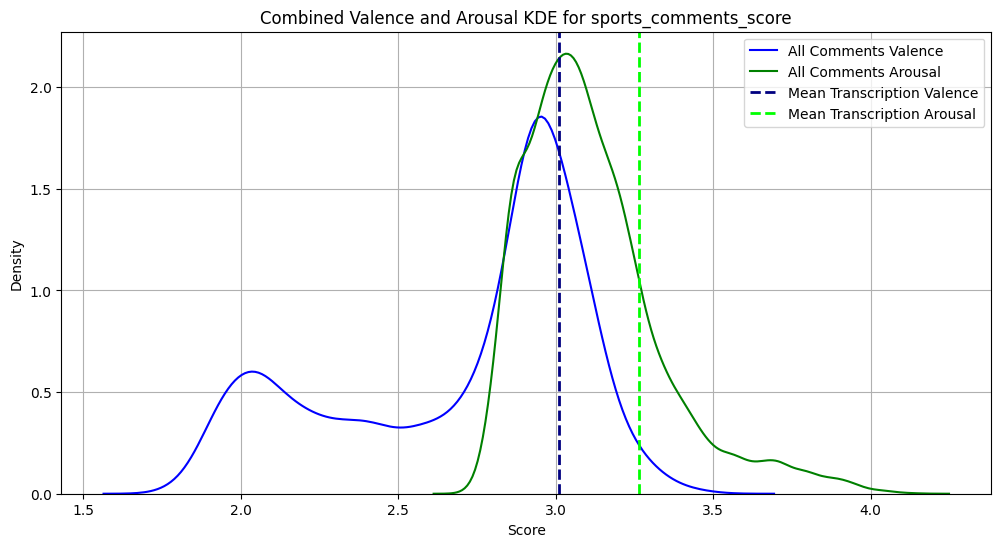

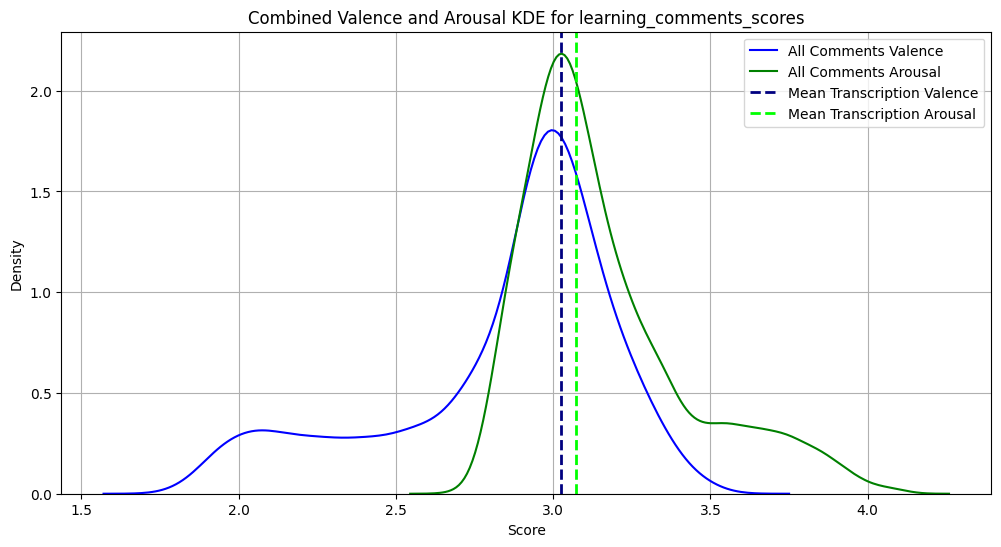

In [198]:
def plot_combined_kde_with_mean(comment_dir, transcription_dir):
    all_comments = pd.DataFrame()
    all_transcriptions = pd.DataFrame()

    comment_csv_files = [f for f in os.listdir(comment_dir) if f.endswith('.csv')]
    
    for comment_file_name in comment_csv_files:
        comment_file_path = os.path.join(comment_dir, comment_file_name)
        comment_df = pd.read_csv(comment_file_path)
        all_comments = pd.concat([all_comments, comment_df], ignore_index=True)
        
        transcription_file_name = next((f for f in os.listdir(transcription_dir) if f.startswith(comment_file_name[:3]) and f.endswith('.csv')), None)
        if transcription_file_name:
            transcription_file_path = os.path.join(transcription_dir, transcription_file_name)
            transcription_df = pd.read_csv(transcription_file_path)
            all_transcriptions = pd.concat([all_transcriptions, transcription_df], ignore_index=True)
    
    # Create a single plot with all data
    plt.figure(figsize=(12, 6))
    if not all_comments.empty:
        sns.kdeplot(data=all_comments, x='Valence', color='blue', label='All Comments Valence')
        sns.kdeplot(data=all_comments, x='Arousal', color='green', label='All Comments Arousal')
    
    if not all_transcriptions.empty:
        mean_valence_transcription = all_transcriptions['Valence'].mean()
        mean_arousal_transcription = all_transcriptions['Arousal'].mean()
        plt.axvline(x=mean_valence_transcription, color='navy', linestyle='--', linewidth=2, label='Mean Transcription Valence')
        plt.axvline(x=mean_arousal_transcription, color='lime', linestyle='--', linewidth=2, label='Mean Transcription Arousal')

    plt.title(f"Combined Valence and Arousal KDE for {os.path.basename(comment_dir)}")
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Directory paths for the datasets
datasets = [
    ('/Users/heyodogo/Documents/projectfiles/news/news_comments_score', '/Users/heyodogo/Documents/projectfiles/news/news_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score', '/Users/heyodogo/Documents/projectfiles/sports/sports_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores', '/Users/heyodogo/Documents/projectfiles/learning/learning_transcriptions_scores')
]

for comments_path, transcriptions_path in datasets:
    plot_combined_kde_with_mean(comments_path, transcriptions_path)


# Calculate and display the Euclidean distance between sentiment scores of comments and their corresponding transcriptions.

In [249]:
def process_files(comments_directory_path, transcription_directory_path):
    comment_csv_files = [f for f in os.listdir(comments_directory_path) if f.endswith('.csv')]
    
    for comment_file_name in comment_csv_files:
        comment_file_path = os.path.join(comments_directory_path, comment_file_name)
        comment_df = pd.read_csv(comment_file_path)
        transcription_file_name = next((f for f in os.listdir(transcription_directory_path) if f.startswith(comment_file_name[:3]) and f.endswith('.csv')), None)
        transcription_file_path = os.path.join(transcription_directory_path, transcription_file_name)
        transcription_df = pd.read_csv(transcription_file_path)
        
        if len(transcription_df) == 1:
            transcription_valence = transcription_df['Valence'].iloc[0]
            transcription_arousal = transcription_df['Arousal'].iloc[0]
            distances = np.sqrt((comment_df['Valence'] - transcription_valence)**2 + (comment_df['Arousal'] - transcription_arousal)**2)
            print(f"Average distance for {comment_file_name[:-11]}: {np.mean(distances):.2f}")

datasets = [
    ('/Users/heyodogo/Documents/projectfiles/news/news_comments_score', '/Users/heyodogo/Documents/projectfiles/news/news_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score', '/Users/heyodogo/Documents/projectfiles/sports/sports_transcriptions_scores'),
    ('/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores', '/Users/heyodogo/Documents/projectfiles/learning/learning_transcriptions_scores')
]

# Process each dataset
for comments_path, transcriptions_path in datasets:
    process_files(comments_path, transcriptions_path)


Average distance for OpenAI employees revolt over Sam Altman firing: 0.50
Average distance for Hear what legal expert found ‘curious’ about Supreme Court’s ruling on Trump: 0.42
Average distance for Genocide in Gaza through the eyes of Israeli soldiers: 0.49
Average distance for BREAKING: Trump suffers SURPRISE LOSS in election: 0.47
Average distance for God and robots: Will AI transform religion? - BBC News: 0.63
Average distance for President Joe Biden takes office amid multiple crises - BBC Newsnight: 0.52
Average distance for Nikki Haley Exits Presidential Race After Trump Dominates Super Tuesday: 0.51
Average distance for Trump: This Is What I Plan To Do If Elected President In 2024: 0.46
Average distance for 2020 REMATCH: Trump going to : 0.47
Average distance for Why Getting A Job Feels Impossible Right Now: 0.50
Average distance for Liverpool 7-0 Manchester United: 0.42
Average distance for WILD ENDING! Final 8 Minutes of Korea Republic v Germany: 0.44
Average distance for Arse

# Aggregate average valence and arousal distances between video comments and transcriptions across multiple domains.

In [255]:
def process_files(comments_directory_path, transcription_directory_path, domain_averages):
    comment_csv_files = [f for f in os.listdir(comments_directory_path) if f.endswith('.csv')]
    domain_valence_distances = []
    domain_arousal_distances = []
    
    for comment_file_name in comment_csv_files:
        comment_file_path = os.path.join(comments_directory_path, comment_file_name)
        comment_df = pd.read_csv(comment_file_path)
        
        transcription_file_name = next((f for f in os.listdir(transcription_directory_path) if f.startswith(comment_file_name[:3]) and f.endswith('.csv')), None)
        
        if transcription_file_name:
            transcription_file_path = os.path.join(transcription_directory_path, transcription_file_name)
            transcription_df = pd.read_csv(transcription_file_path)
        
            if len(transcription_df) == 1:
                transcription_valence = transcription_df['Valence'].iloc[0]
                transcription_arousal = transcription_df['Arousal'].iloc[0]
                valence_distances = np.abs(comment_df['Valence'] - transcription_valence)
                arousal_distances = np.abs(comment_df['Arousal'] - transcription_arousal)
                
                domain_valence_distances.append(np.mean(valence_distances))
                domain_arousal_distances.append(np.mean(arousal_distances))

    if domain_valence_distances:
        domain_averages['Valence'].append(np.mean(domain_valence_distances))
    if domain_arousal_distances:
        domain_averages['Arousal'].append(np.mean(domain_arousal_distances))

# Directory paths for datasets
datasets = [
    ('news', '/Users/heyodogo/Documents/projectfiles/news/news_comments_score', '/Users/heyodogo/Documents/projectfiles/news/news_transcriptions_scores'),
    ('sports', '/Users/heyodogo/Documents/projectfiles/sports/sports_comments_score', '/Users/heyodogo/Documents/projectfiles/sports/sports_transcriptions_scores'),
    ('learning', '/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores', '/Users/heyodogo/Documents/projectfiles/learning/learning_transcriptions_scores')
]

domain_averages = {'Domain': [], 'Valence': [], 'Arousal': []}

# Process each dataset
for domain, comments_path, transcriptions_path in datasets:
    domain_averages['Domain'].append(domain)
    process_files(comments_path, transcriptions_path, domain_averages)

domain_averages_df = pd.DataFrame(domain_averages)
print(domain_averages_df)


     Domain   Valence   Arousal
0      news  0.428121  0.184292
1    sports  0.364554  0.245800
2  learning  0.306119  0.195278


# Consolidate all the Euclidian distances across Domains into one signular csv

In [149]:
import pandas as pd

# File paths for the CSV files
learning_distances_file = '/Users/heyodogo/Downloads/learning_distances.csv'
sports_distances_file = '/Users/heyodogo/Downloads/sports_distances.csv'
news_distances_file = '/Users/heyodogo/Downloads/news_distances.csv'

# Read each CSV file and add a domain column
learning_df = pd.read_csv(learning_distances_file)
learning_df['Domain'] = 'Learning'

sports_df = pd.read_csv(sports_distances_file)
sports_df['Domain'] = 'Sports'

news_df = pd.read_csv(news_distances_file)
news_df['Domain'] = 'News'

# Concatenate all dataframes into one
consolidated_df = pd.concat([learning_df, sports_df, news_df], ignore_index=True)

# Save the consolidated DataFrame to a new CSV
consolidated_df.to_csv('/Users/heyodogo/Downloads/consolidated_distances.csv', index=False)

# Display the consolidated DataFrame
print(consolidated_df)


                                                Video  Average Distance  \
0   Natural Language Processing: Crash Course Comp...          0.398743   
1       Can a Simple Brick Be the Next Great Battery?          0.402797   
2                  The sugar water barber pole effect          0.355968   
3                      Algebraic Approach to this one          0.443920   
4           Shark Biology | JONATHAN BIRDS BLUE WORLD          0.435828   
5                              How a Car Engine Works          0.437000   
6           Is Climate Change Slowing Down the Ocean?          0.406353   
7   How do I find x? Exponential equation with two...          0.366354   
8        Work, Energy, and Power - Basic Introduction          0.444703   
9                               Logarithms - Formulas          0.412932   
10                    Liverpool 7-0 Manchester United          0.420008   
11  WILD ENDING! Final 8 Minutes of Korea Republic...          0.438822   
12                    Ars

# Aggregate the Average Eucledian Distances across the 3 domains

In [231]:
import pandas as pd

consolidated_df = pd.read_csv('/Users/heyodogo/Downloads/consolidated_distances.csv')

domain_averages = consolidated_df.groupby('Domain')['Average Distance'].mean().reset_index()

domain_averages.to_csv('/Users/heyodogo/Downloads/domain_average_distances.csv', index=False)

print(domain_averages)


     Domain  Average Distance
0  Learning          0.410460
1      News          0.497531
2    Sports          0.498484


# Plot the comments's scores onto a 2d plane

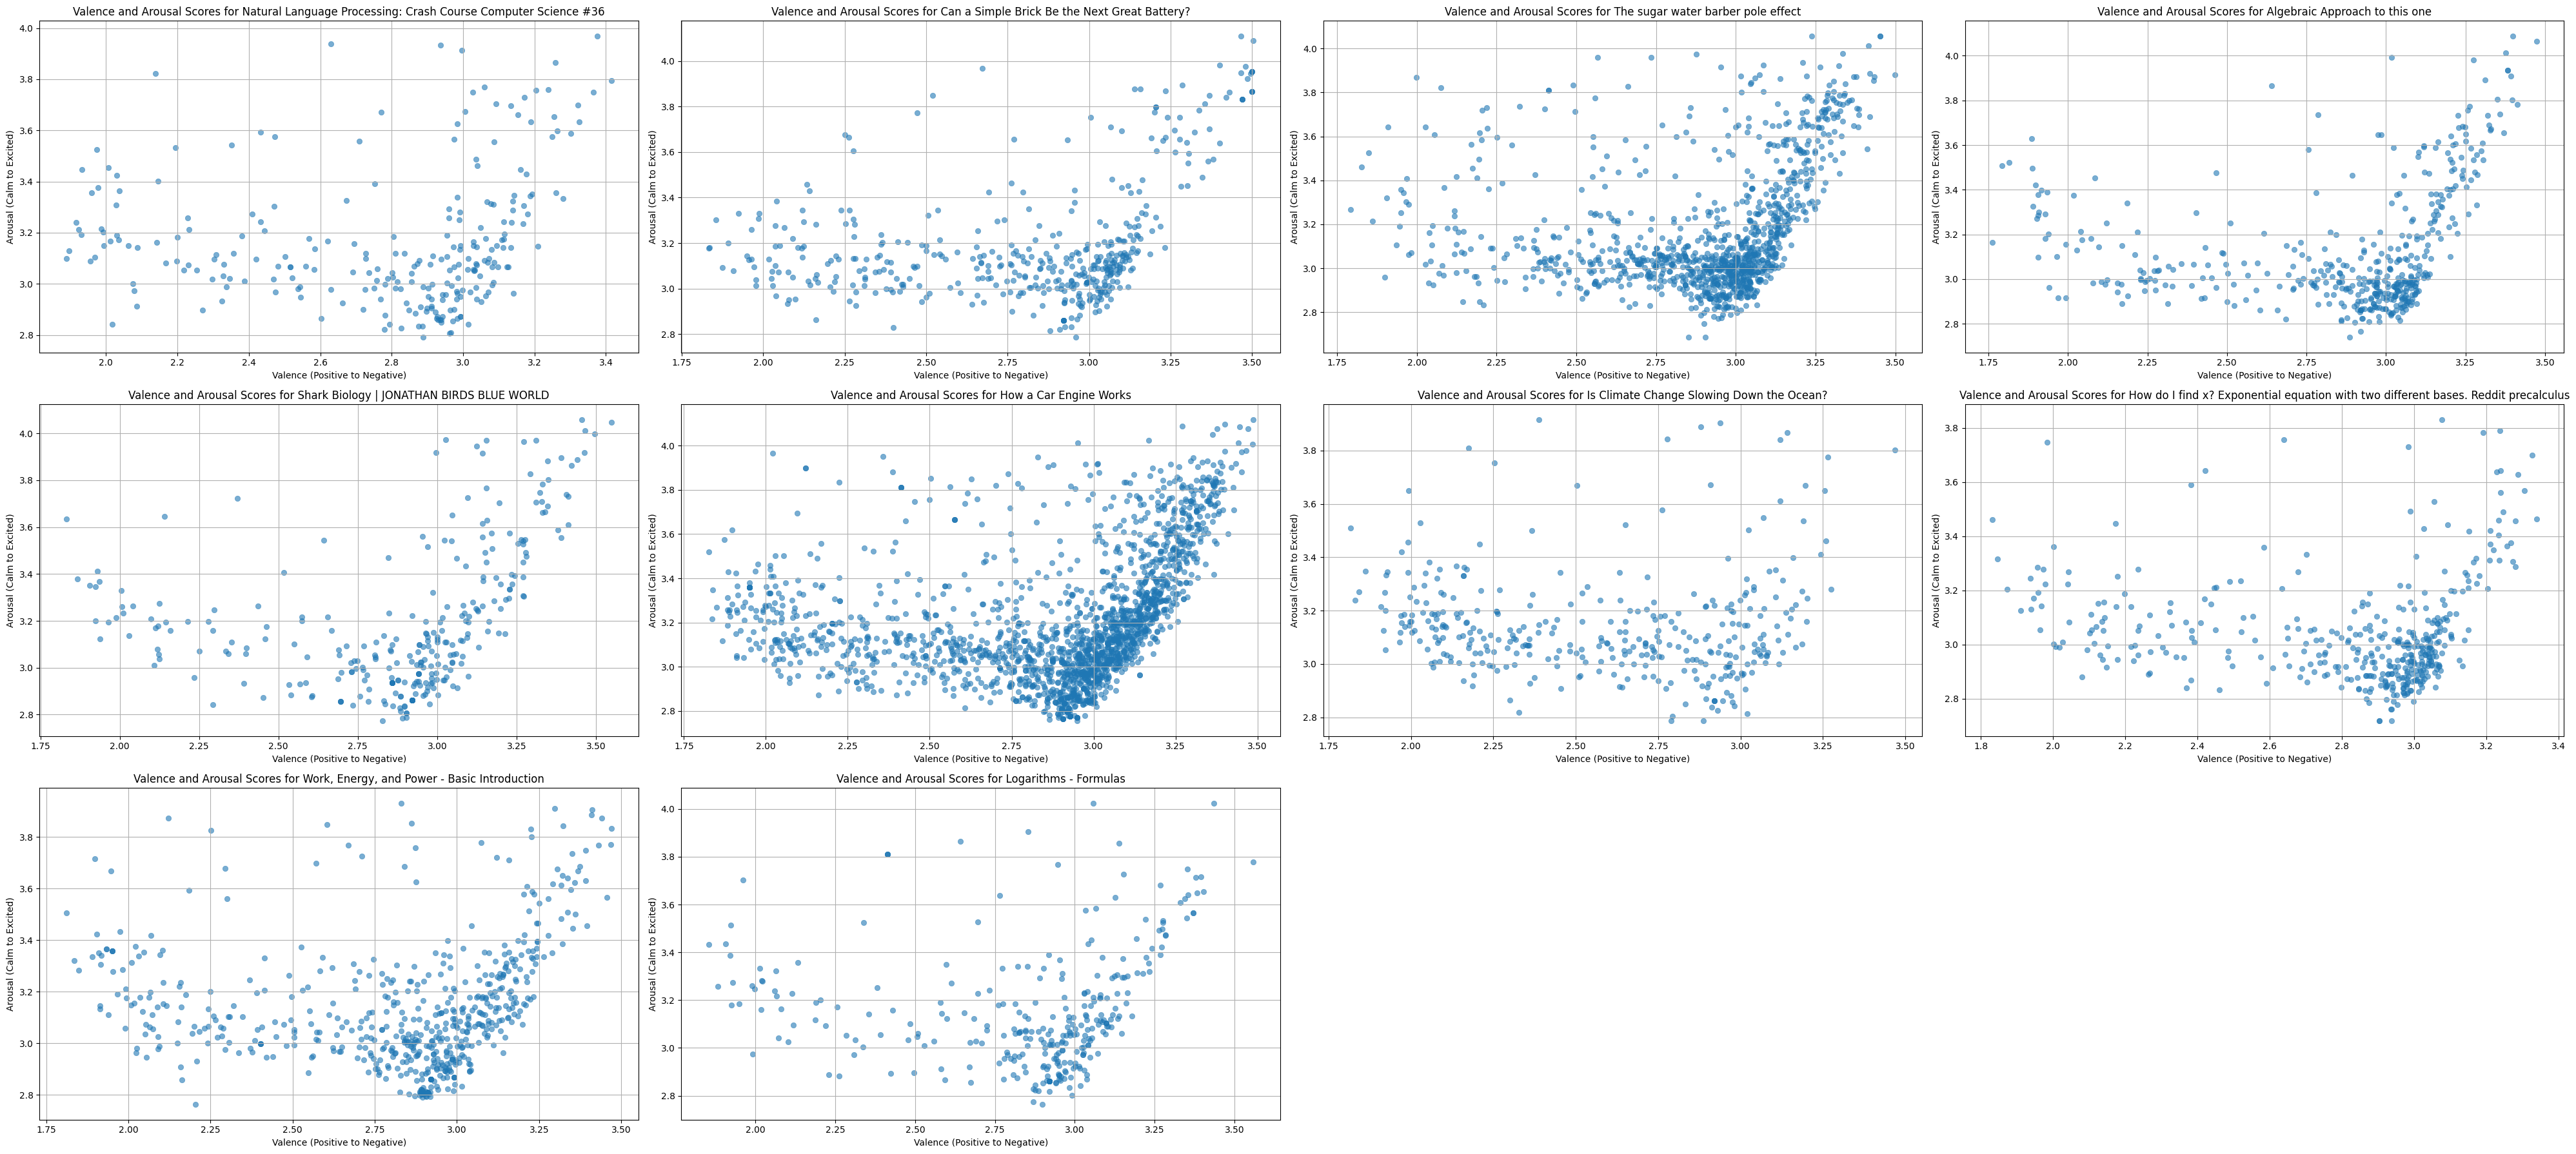

In [77]:
directory_path = '/Users/heyodogo/Documents/projectfiles/learning/learning_comments_scores'

csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
num_files = len(csv_files)
num_rows = int(num_files ** 0.5)
num_cols = (num_files + num_rows - 1) // num_rows 

plt.figure(figsize=(10 * num_cols, 6 * num_rows))

for index, file_name in enumerate(csv_files, start=1):
    file_path = os.path.join(directory_path, file_name)
    df = pd.read_csv(file_path)

    plt.subplot(num_rows, num_cols, index)
    sns.scatterplot(data=df, x='Valence', y='Arousal', alpha=0.6, edgecolor=None)
    plt.title(f'Valence and Arousal Scores for {file_name.replace("_scores.csv", "")}')
    plt.xlabel('Valence (Positive to Negative)')
    plt.ylabel('Arousal (Calm to Excited)')
    plt.grid(True)

plt.tight_layout()
plt.show()
p

In [ ]:
# Plot the transcriptoins's scores onto a 2d plane

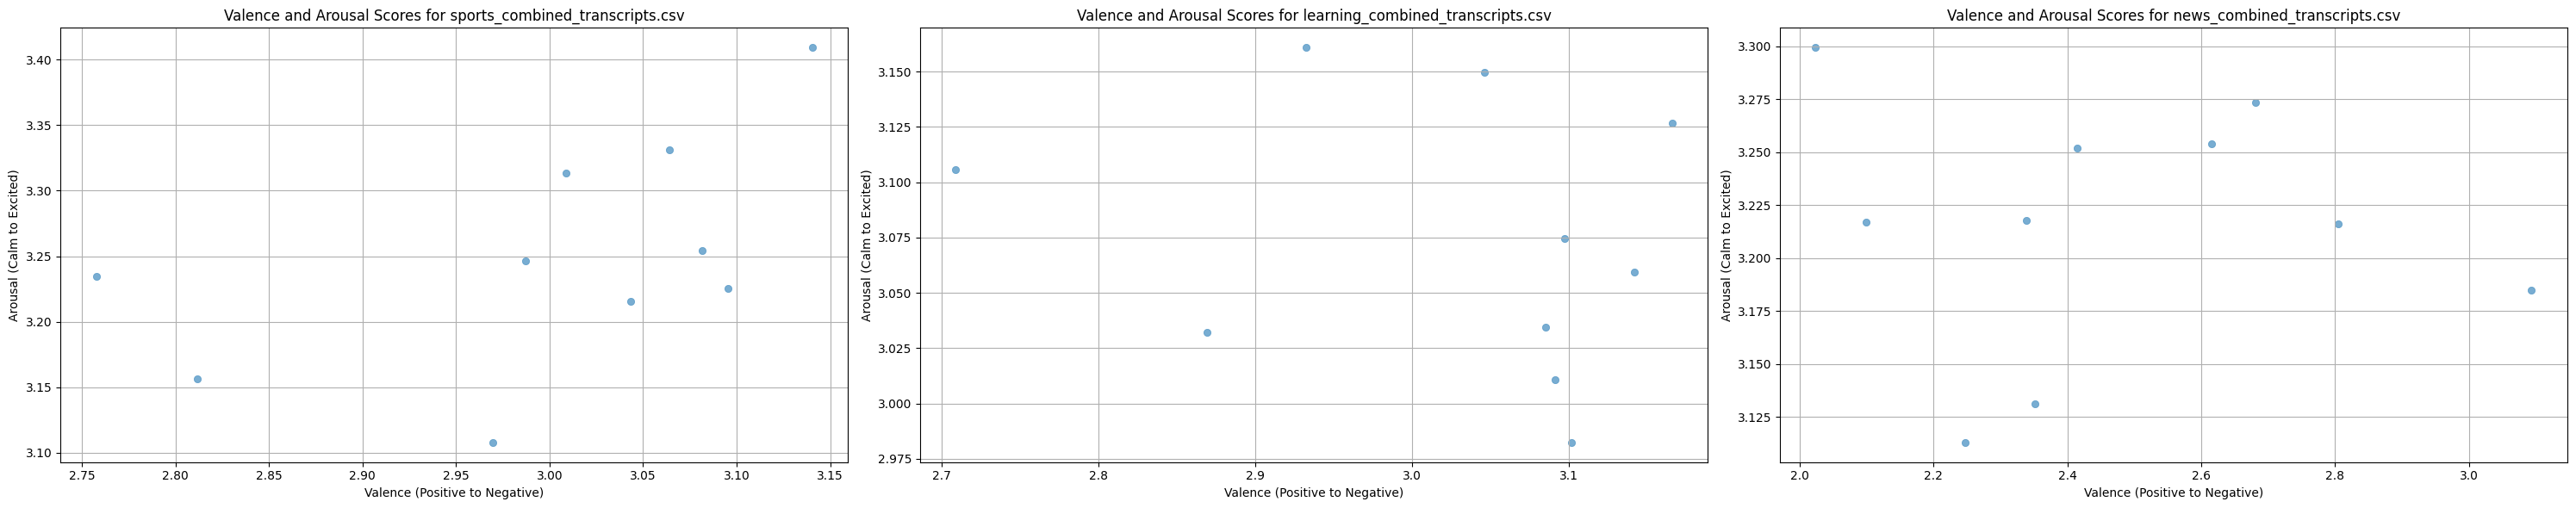

In [74]:
directory_path = '/Users/heyodogo/Documents/projectfiles/'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

# Determine the layout of the subplots
num_files = len(csv_files)
num_rows = int(num_files ** 0.5)
num_cols = (num_files + num_rows - 1) // num_rows  

# Create a figure to hold all subplots
plt.figure(figsize=(10 * num_cols, 6 * num_rows))

for index, file_name in enumerate(csv_files, start=1):
    file_path = os.path.join(directory_path, file_name)
    df = pd.read_csv(file_path)

    plt.subplot(num_rows, num_cols, index)
    sns.scatterplot(data=df, x='Valence', y='Arousal', alpha=0.6, edgecolor=None)
    plt.title(f'Valence and Arousal Scores for {file_name.replace("_scores.csv", "")}')
    plt.xlabel('Valence (Positive to Negative)')
    plt.ylabel('Arousal (Calm to Excited)')
    plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()